# EXPLAINABILITY OF THE TRAINED MODEL

This notebook details the explainability analysis (XAI) of the toxicity classification model, which is based on a fine-tuned DistilBERT model trained on the Jigsaw Toxic Comment Classification dataset. We employ several XAI methods to generate both local and global explanations. The goal is to provide transparent and interpretable insights into the model's decision process, revealing how textual features contribute to specific toxicity classes, understanding model behavior, and identifying potential biases for future improvement and deployment.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from src.utils import load_model
from src.data import load_and_prepare_datasets

c:\Master\XIA\ToxicityDetection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load trained model and tokenizer

In [4]:
model, tokenizer = load_model("models/distilbert_toxic", device=device)
model.eval()

[INFO] Loading model from: models/distilbert_toxic
[INFO] Model loaded successfully.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Inference function for the model

In [5]:
def predict_probs(text):
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()
    return probs

Test Data

This analysis exclusively uses samples from the dataset's test split. The test set contains unseen data, which is the most reliable source for evaluating both predictive performance and interpretability. Using unseen data ensures the explanations reflect the model’s true generalization behavior rather than memorization, avoiding overestimation of robustness. By comparing the model’s predictions on these samples with ground-truth labels, we gain a realistic and unbiased understanding of the decision process, supporting trustworthy and scientifically valid interpretation.

In [6]:
datasets, id2label = load_and_prepare_datasets(
    tokenizer=tokenizer,
    max_length=128,
    val_size=0.1,
    test_size=0.1,
    seed=42
)

test_set = datasets["test"]
len(test_set)

Jigsaw dataset already exists. Skipping download.


Map: 100%|██████████| 15958/15958 [00:02<00:00, 6312.94 examples/s]


15958

In [7]:
i = 4
sample = test_set[i]

text = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
label = sample["labels"]

print("TEXT:", text)
print("TRUE LABELS:", label.numpy())
print("CLASS NAMES:", id2label)

TEXT: fuck you wanker
TRUE LABELS: [1. 1. 1. 0. 1. 0.]
CLASS NAMES: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


Lets search for samples for all the combinations possible

Let's remember the final metrics we achieved after training our DistilBERT model for 3 epochs.

| Metric | Score |
| :--- | :--- |
| **Test F1-micro** | **0.7856** |
| **Test F1-macro** | **0.6485** |

***

How to Read These Metrics?

The metrics we got are completely **normal and healthy**, showing the model learned effectively without overfitting too much.

* The F1-micro score (around **0.79**) is strong and shows good **generalization**, it's performing well on new data it's never seen. The small difference between the training F1-micro (~0.87) and the validation F1-micro (~0.79) is good; it means the model is **stable** and not just memorizing the training examples.

* The F1-macro score (around **0.65**) is lower, but that is **expected** for the Jigsaw dataset. The F1-macro score is pulled down by the **imbalance** in the data, where super rare labels (like *threat* or *identity\_hate*) get low individual scores.

Here's how these two scores are calculated:

* **F1-micro:** It calculates the F1 score globally, counting up the total correct and incorrect predictions across all labels. It basically treats all predictions as a single, combined pool.

    $$
    \text{F1}_{\text{micro}} =
    \frac{2 \cdot \text{TP}}
        {\,2 \cdot \text{TP} + \text{FP} + \text{FN}\,}
    $$


* **F1-macro:** It calculates the F1 score for *each* of the six toxicity labels separately, and then takes a simple average of those six scores.

    $$
    \text{F1}_{\text{macro}} =
    \frac{1}{6}
    \sum_{i=1}^{6} \text{F1}_i
    $$


In [8]:
# combos[combo] = {"correct": idx, "wrong": idx}
combos = {}

for i, sample in enumerate(test_set):
    labels = tuple(int(x) for x in sample["labels"].numpy())

    text = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

    # true labels
    true_labels = np.array(labels)

    # pred
    pred_probs = predict_probs(text)
    pred_labels = (pred_probs >= 0.5).astype(int)

    correct = np.array_equal(true_labels, pred_labels)

    if labels not in combos:
        combos[labels] = {"correct": None, "wrong": None}

    # Save a correct sample
    if correct and combos[labels]["correct"] is None:
        combos[labels]["correct"] = {
            "index": i,
            "text": text,
            "combo_true": labels,
            "combo_pred": tuple(pred_labels)
        }

    # Save an incorrect sample
    if (not correct) and combos[labels]["wrong"] is None:
        combos[labels]["wrong"] = {
            "index": i,
            "text": text,
            "combo_true": labels,
            "combo_pred": tuple(pred_labels)
        }

    if combos[labels]["correct"] is not None and combos[labels]["wrong"] is not None:
        continue


sorted_combos = sorted(combos.items(), key=lambda x: x[0])

for combo, data in sorted_combos:
    print("\n==========================================")
    print("COMBO:", combo)

    if data["correct"]:
        c = data["correct"]
        print(f"✔ CORRECT — idx {c['index']}")
        print("TRUE:", c["combo_true"])
        print("PRED:", c["combo_pred"])
        print("TEXT:", c["text"])
    else:
        print("✔ CORRECT — NOT FOUND")

    print("---")

    if data["wrong"]:
        w = data["wrong"]
        print(f"✘ INCORRECT — idx {w['index']}")
        print("TRUE:", w["combo_true"])
        print("PRED:", w["combo_pred"])
        print("TEXT:", w["text"])
    else:
        print("✘ INCORRECT — NOT FOUND")



COMBO: (0, 0, 0, 0, 0, 0)
✔ CORRECT — idx 0
TRUE: (0, 0, 0, 0, 0, 0)
PRED: (0, 0, 0, 0, 0, 0)
TEXT: censorship science apologist - i do not know of any wiki rule or policy that gives one editor the right to censor the contribution of another editor. if you have a problem with the contribution i am trying to make to the clairvoyance article, please intelligently and articulately communicate your concerns on my talk page. simply clicking on undo, as you have done before, is not science. it is censorship. if it continues i will have to commence dr action. best wishes. ramesbury
---
✘ INCORRECT — idx 43
TRUE: (0, 0, 0, 0, 0, 0)
PRED: (1, 0, 0, 0, 0, 0)
TEXT: " your mouth is your worst enemy guy matthew 7 : 12 " " therefore whatever you want men to do to you, do also to them, for this is the law and the prophets " " matthew 12 : 36 - 37 " " but i say to you that for every idle word men may speak, they will give account of it in the day of judgement " " " " for your words you will be justif

Rather than visualising attention patterns for all label combinations, we use the combos structure to select a small set of representative test examples. For each relevant label configuration, we inspect one correctly classified instance and one misclassified instance whenever available. This allows us to study attention behaviour in a focused and interpretable way, while avoiding an overwhelming number of similar plots that would not provide additional insight.

In [9]:
count_correct = 0
count_wrong = 0
total_combos = len(combos)

for combo, data in combos.items():
    if data["correct"] is not None:
        count_correct += 1
    if data["wrong"] is not None:
        count_wrong += 1

print("============== RESULTS ==============")
print(f"Total combos: {total_combos}")
print(f"Combinations with at least one correct prediction: {count_correct}")
print(f"Combinations with at least one incorrect predicton: {count_wrong}")
print(f"Combinations without a correct prediction: {total_combos - count_correct}")
print("======================================")

============== RESULTS ==============
Total combos: 29
Combinations with at least one correct prediction: 14
Combinations with at least one incorrect predicton: 29
Combinations without a correct prediction: 15


In multilabel classification tasks like Jigsaw Toxicity, requiring an exact match across all six labels leads to expected inaccuracies. This is primarily due to the high data imbalance (rare labels and combinations are sparse or absent) and the strictness of the metric. Since labels are predicted independently, predicting all six correctly is challenging. Thus, while common label patterns succeed, failure on rare or complex combinations is considered normal and expected model behavior.

## Attention visualization
In this section, we begin our exploratory analysis by visualizing the attention weights of the fine-tuned DistilBERT model. This provides an initial intuition into how the model processes input text, revealing which tokens are attended to across different layers and heads. However, it's crucial to note that attention weights are not faithful explanations of the model’s predictions; their relationship to true feature importance is limited. They primarily reflect internal representational dynamics. Therefore, this visualization serves solely as an exploratory diagnostic tool before we proceed to more reliable explanation methods, such as gradient-based saliency, LIME, and SHAP.

In [10]:
def get_attention(text):
    """
    Tokenizes the input text, runs it through the model,
    and returns:
      - tokens (list of strings)
      - attentions (list of tensors, one per layer)
    """
    device = model.device

    encoded = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoded, output_attentions=True)

    tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])

    # attentions[l].shape = (batch, num_heads, seq_len, seq_len)
    attentions = outputs.attentions

    return tokens, attentions

In [60]:
def plot_all_heads(tokens, attention_matrix, name, layer):
    num_heads = attention_matrix.shape[0]
    seq_len = len(tokens)

    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.flatten()

    for h in range(num_heads):
        ax = axes[h]
        attn = attention_matrix[h].cpu().numpy()
        im = ax.matshow(attn, cmap='viridis')
        ax.set_title(f"Head {h}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(f"attention_visualization/layer_{layer}_{name}")
    plt.show()


selected combos for visualization

In [31]:
selected_examples = [
    # COMBO (0,0,0,0,0,0)
    ("neutral_correct", 0),
    ("neutral_wrong", 43),

    # COMBO (0,0,0,0,0,1)
    ("identity_hate_wrong", 1906),

    # COMBO (0,0,0,0,1,0)
    ("insult_wrong", 260),

    # COMBO (0,0,0,0,1,1)
    ("insult_idhate_wrong", 2980),

    # COMBO (0,0,1,0,0,0)
    ("obscene_wrong", 248),

    # COMBO (1,0,0,0,0,0)
    ("toxic_correct", 103),
    ("toxic_wrong", 14),

    # COMBO (1,0,0,0,0,1)
    ("toxic_identity_correct", 865),

    # COMBO (1,0,0,1,0,0)
    ("threat_correct", 949),

    # COMBO (1,0,1,0,1,1)
    ("multi_correct", 424),

    # COMBO (1,1,1,1,1,1)
    ("max_toxic_wrong", 469),
]

In [32]:
def load_selected_examples(test_set, tokenizer, predict_probs, selected_examples):
    loaded = []

    for label, idx in selected_examples:
        sample = test_set[idx]
        text = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
        true_combo = tuple(int(x) for x in sample["labels"].numpy())

        preds = predict_probs(text)
        pred_combo = tuple(int(x >= 0.5) for x in preds)

        loaded.append({
            "label": label,
            "index": idx,
            "text": text,
            "true_combo": true_combo,
            "pred_combo": pred_combo,
            "pred_probs": preds
        })

    return loaded


examples = load_selected_examples(test_set, tokenizer, predict_probs, selected_examples)
len(examples)


12


Label name: neutral_correct
Index:      0
True combo: (0, 0, 0, 0, 0, 0)
Pred combo: (0, 0, 0, 0, 0, 0)
TEXT: censorship science apologist - i do not know of any wiki rule or policy that gives one editor the right to censor the contribution of another editor. if you have a problem with the contribution i am trying to make to the clairvoyance article, please intelligently and articulately communicate your concerns on my talk page. simply clicking on undo, as you have done before, is not science. it is censorship. if it continues i will have to commence dr action. best wishes. ramesbury


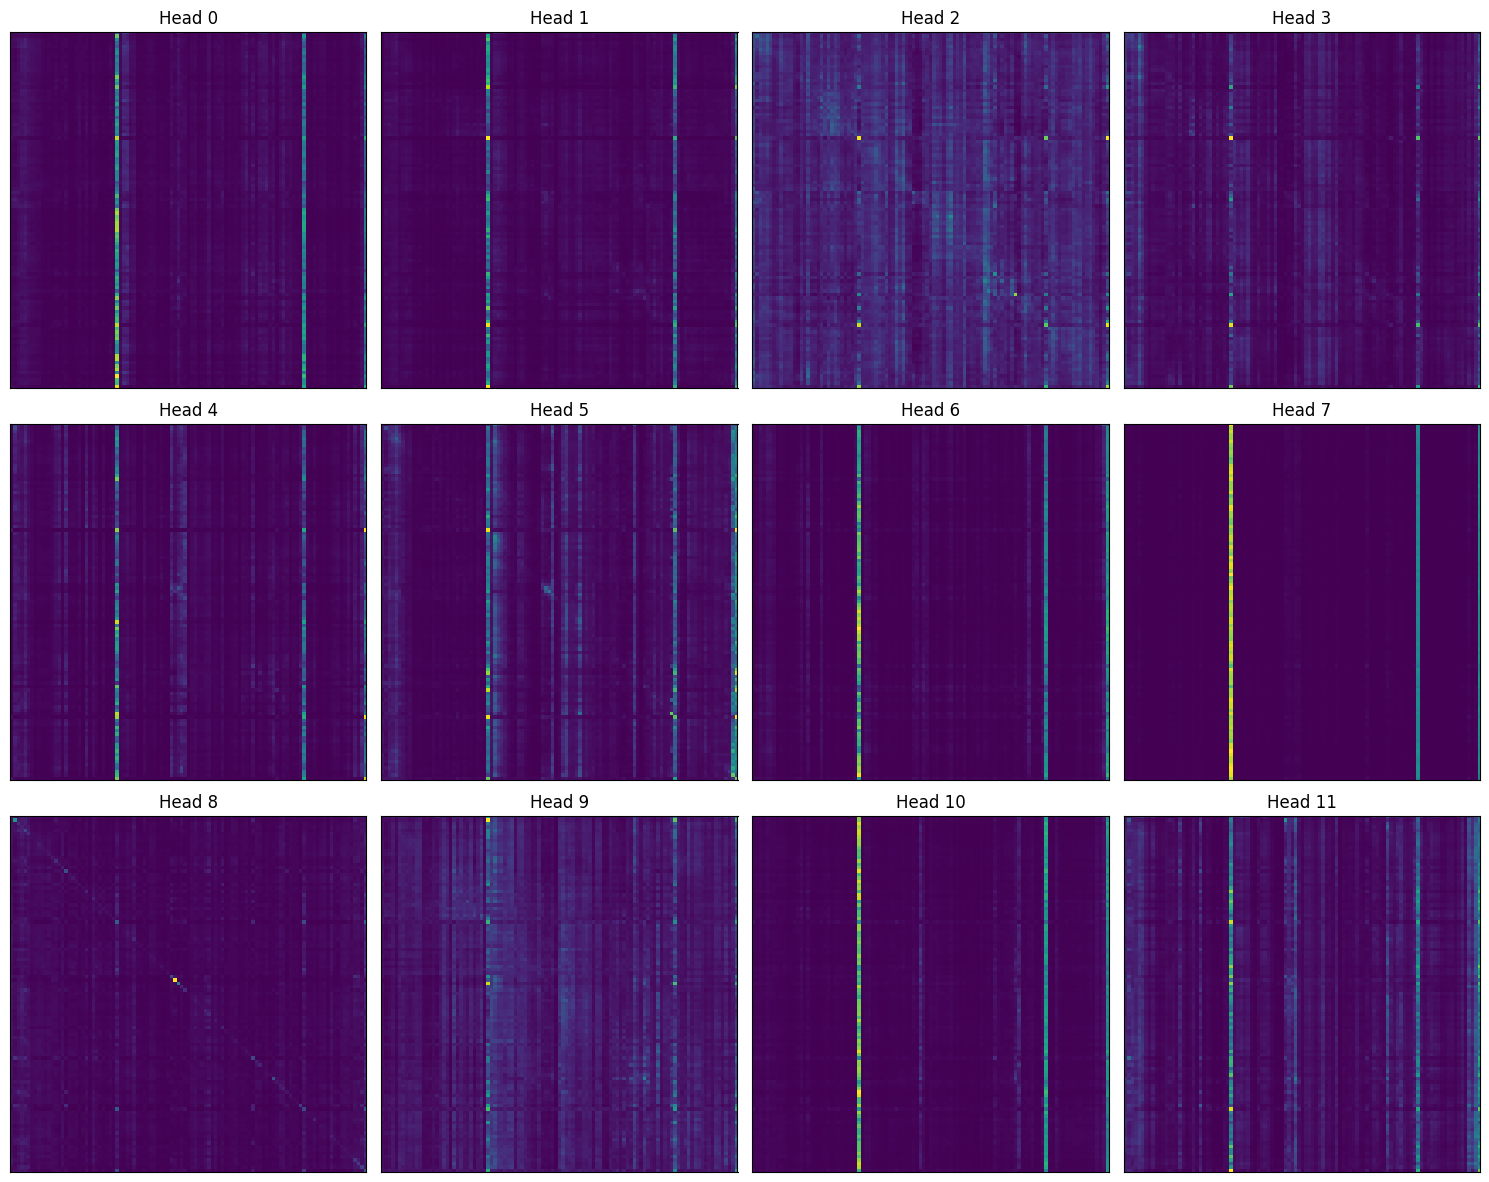


Label name: neutral_wrong
Index:      43
True combo: (0, 0, 0, 0, 0, 0)
Pred combo: (1, 0, 0, 0, 0, 0)
TEXT: " your mouth is your worst enemy guy matthew 7 : 12 " " therefore whatever you want men to do to you, do also to them, for this is the law and the prophets " " matthew 12 : 36 - 37 " " but i say to you that for every idle word men may speak, they will give account of it in the day of judgement " " " " for your words you will be justified and your words you will be condemned " " james 3 : 8 but no man cam tame the tongue, it is an unruly evil, full of deadly poison. james 3 : 9 with it we bless our


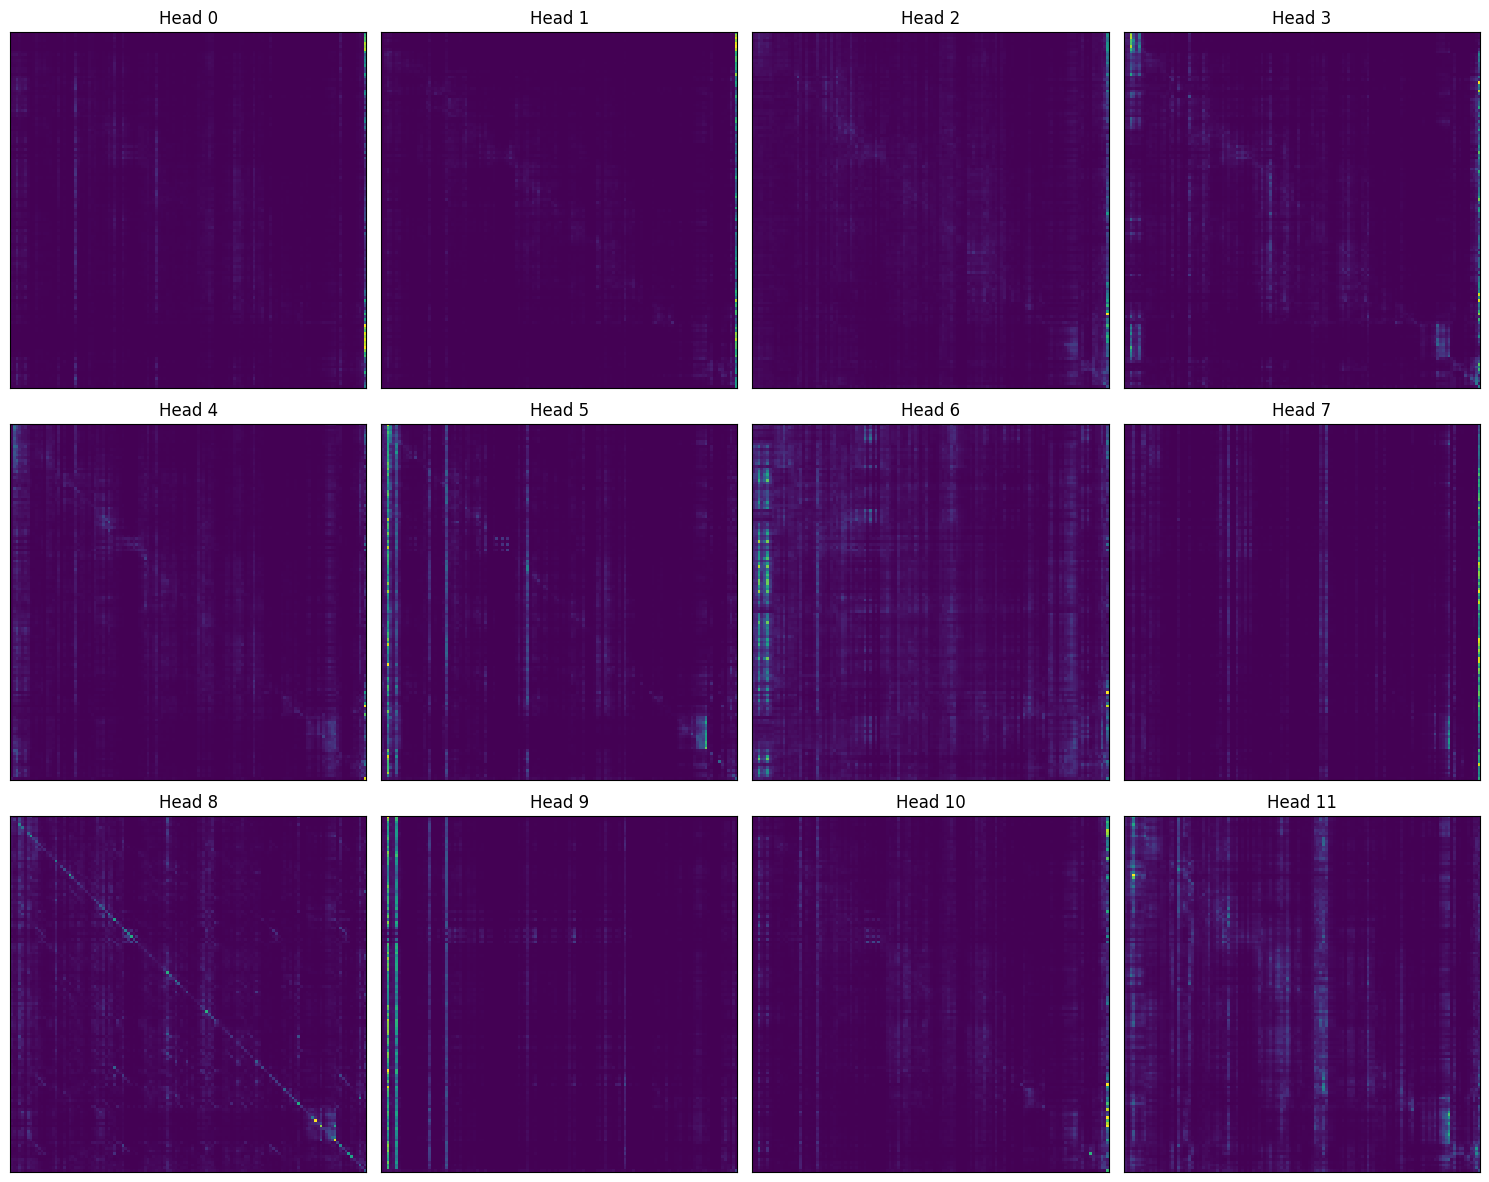


Label name: identity_hate_wrong
Index:      1906
True combo: (0, 0, 0, 0, 0, 1)
Pred combo: (1, 0, 0, 0, 0, 1)
TEXT: i need to leave fisherqueen a message... we ' re back!!!!!!!!!!!!!! well only on this page.. but soon we will be after you!!!!!!!!!!!! just kidding... maybe... you will never know! they are after you and your lesbian friends!!!!!! and merope, you cant call that comment pearsonal offence because it says on her user page!!!!!!!!!!!!!!!!!!!!!


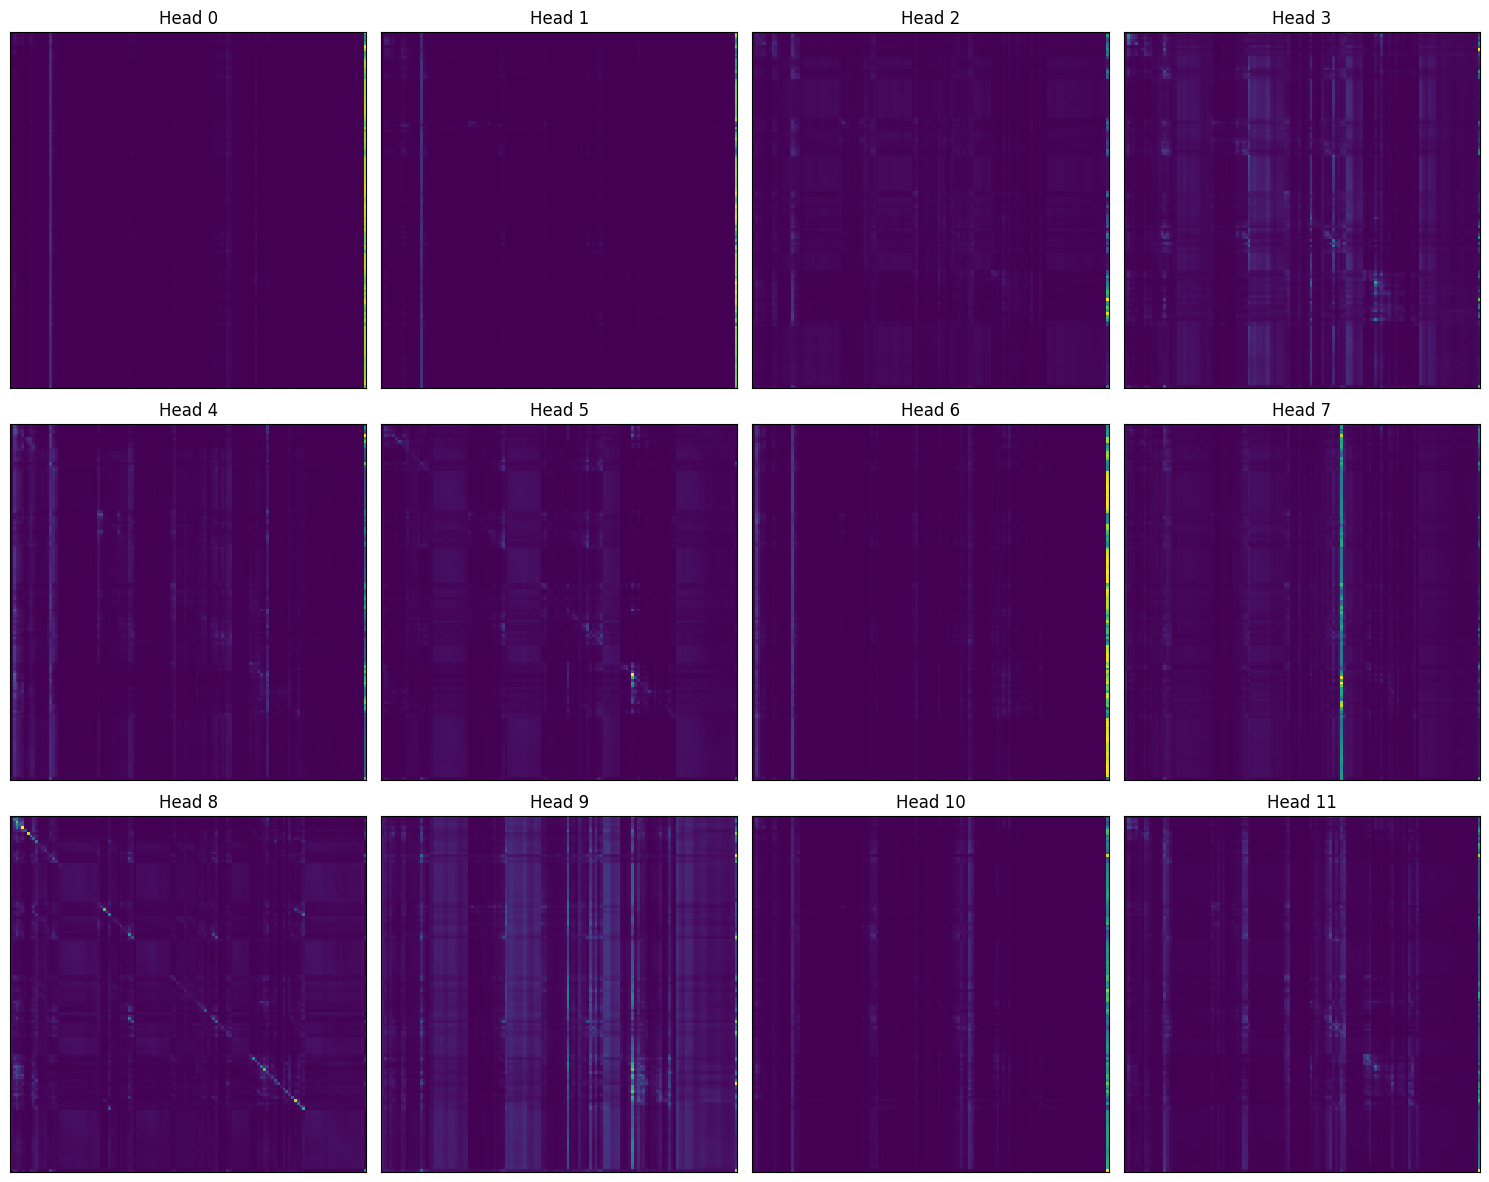


Label name: insult_wrong
Index:      260
True combo: (0, 0, 0, 0, 1, 0)
Pred combo: (0, 0, 0, 0, 0, 0)
TEXT: wow you win so, you, as a queen bee, with your lovely photo, wanting attention, have succeeded in getting rid of another woman ' s bio that i wanted posted. you do not even understand mathematics ; it is beyond you you have no idea what mathematics is. do you think calculus is the ultimate? well it is not. you are a sockpuppet, with a fake boyfriend. you do not even understand how mathematics leads to cures for hearing impairment. well, congratulations ; i have been fired because of you, you lovely young woman with wonderful attitude. you must be so proud that you won your battle.


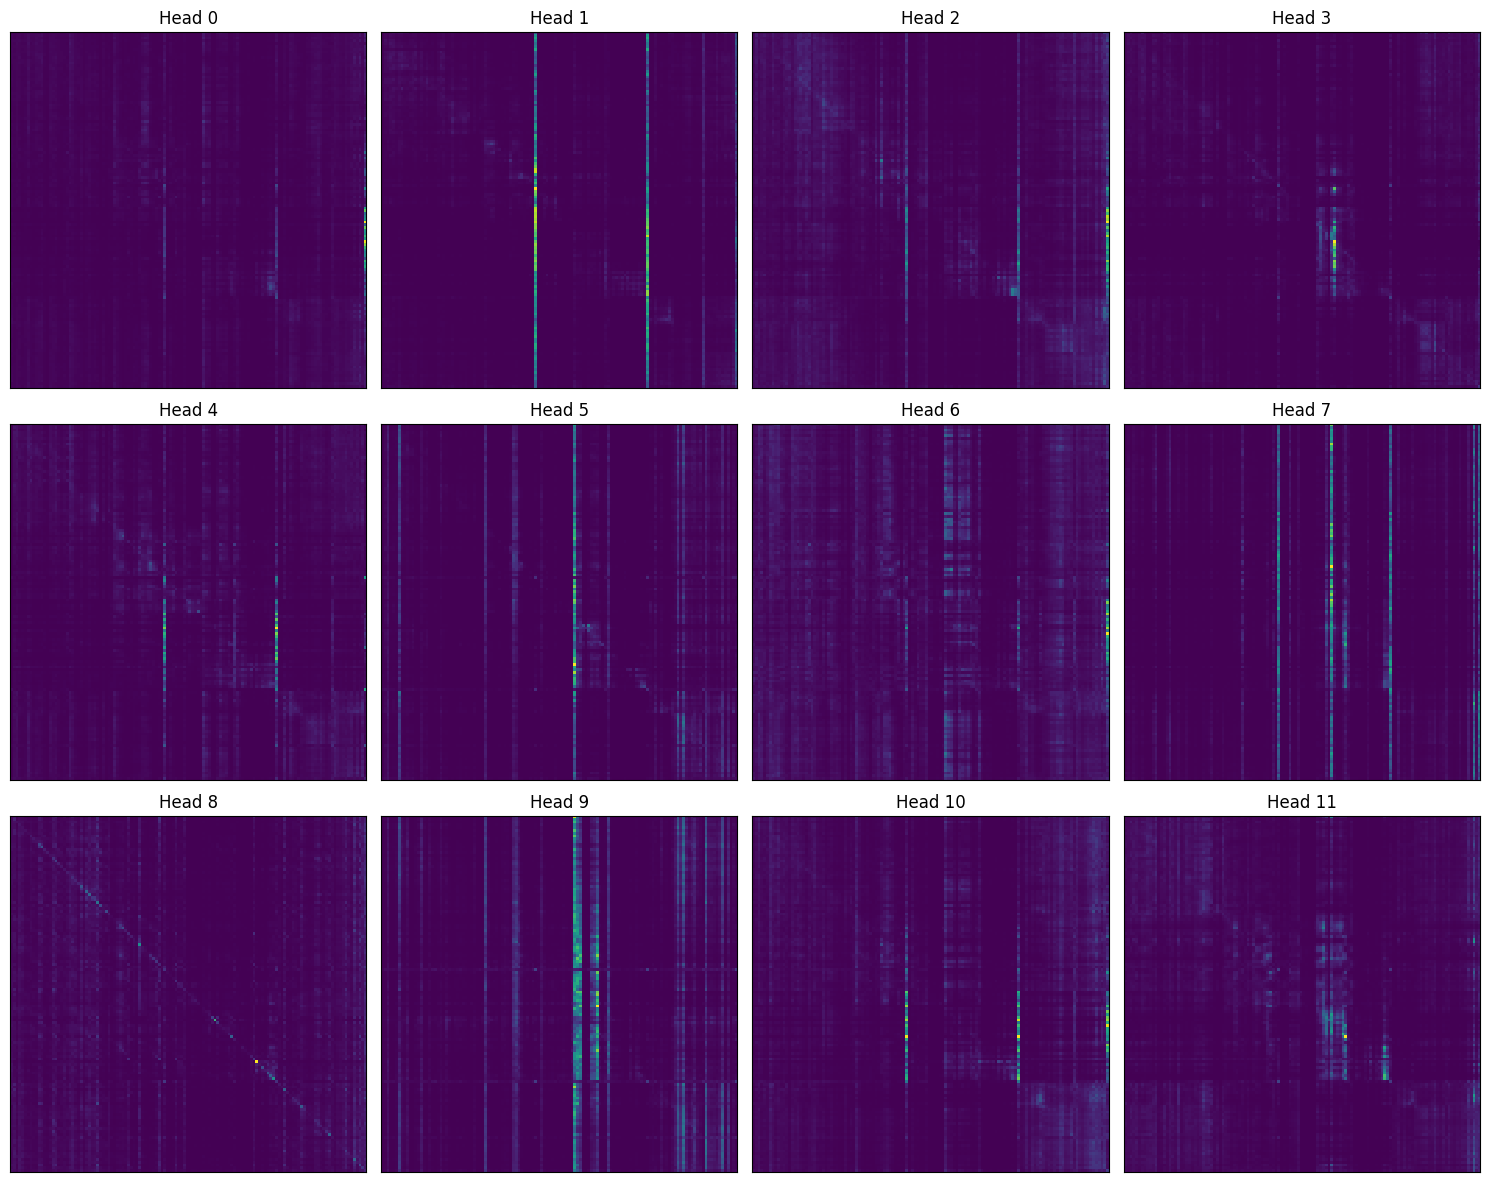


Label name: insult_idhate_wrong
Index:      2980
True combo: (0, 0, 0, 0, 1, 1)
Pred combo: (0, 0, 0, 0, 0, 0)
TEXT: it doesn ' t matter what i think. i ' m a big retarded antisemite. i ' m - a go throw myself in front of an sixteen - wheeler with the grill covered in razor wire and video - tape it for you. people will find the lone tripod on the side of the road, see the video, think it ' s lulzy, then put it on youtube for posterity. and that ' s my last post. williamh, sorry for wasting your time. everyone else, search ' antisemite vs. truck ' on the yt in a few days. no wait


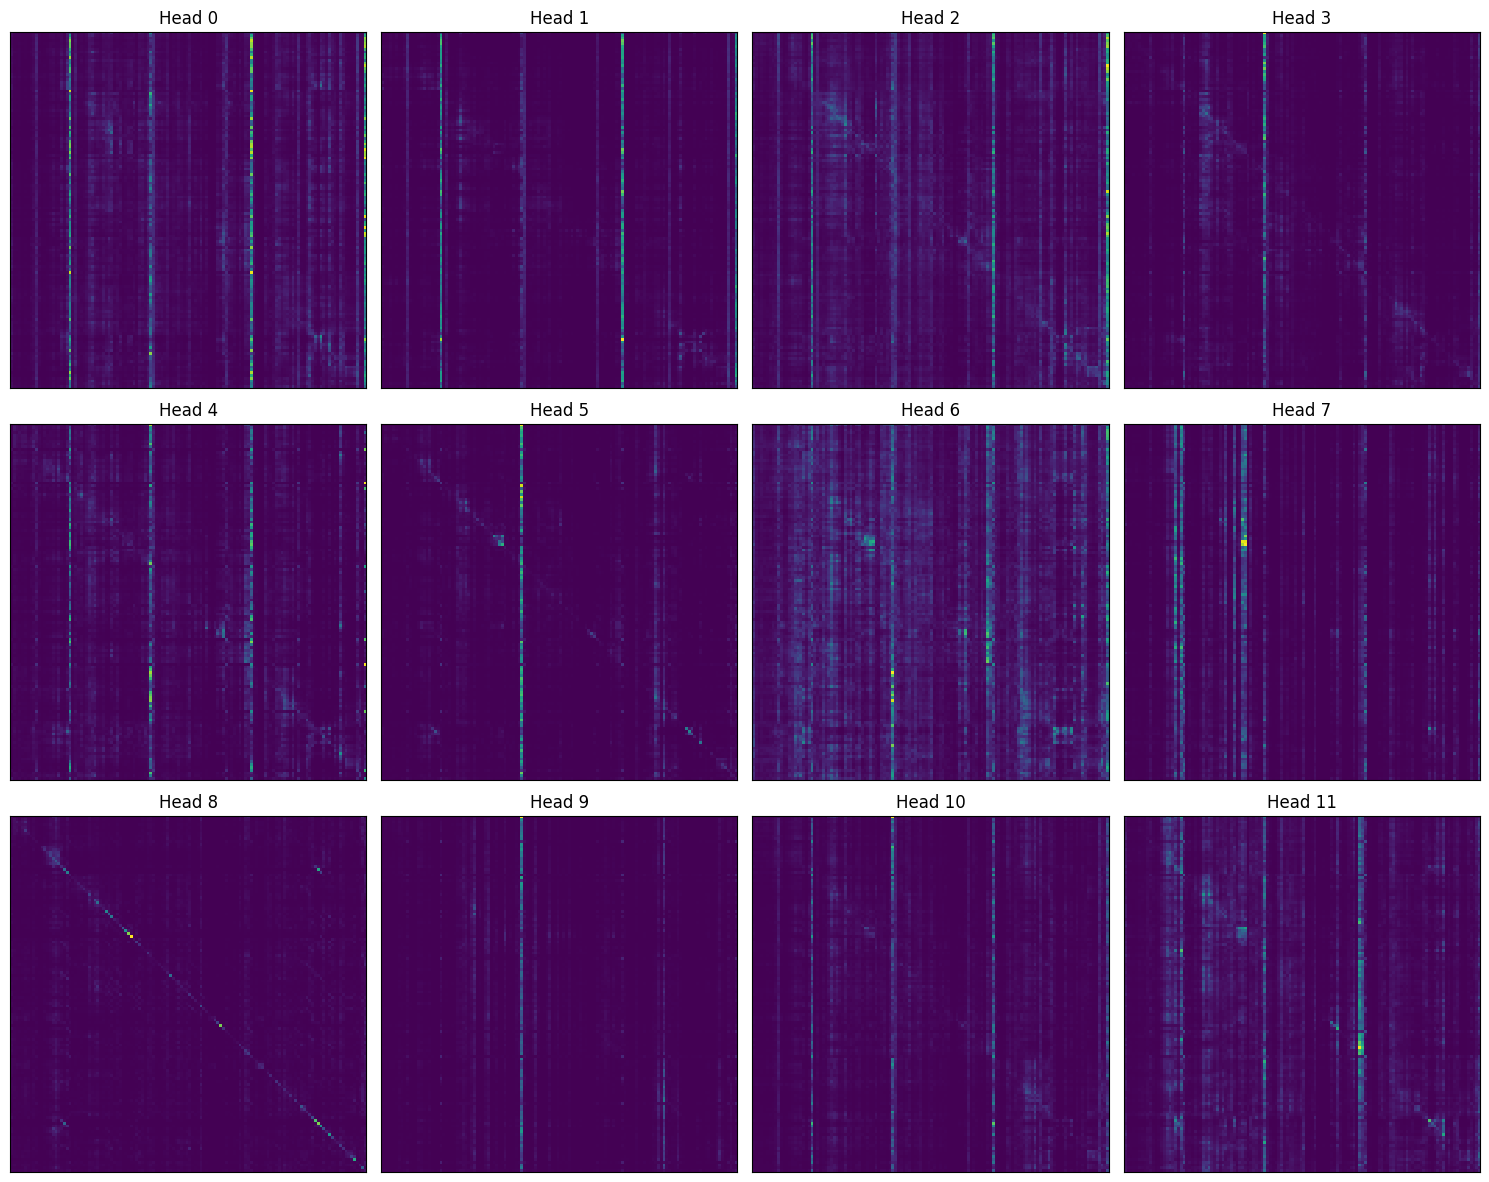


Label name: obscene_wrong
Index:      248
True combo: (0, 0, 1, 0, 0, 0)
Pred combo: (1, 0, 1, 0, 0, 0)
TEXT: " this would be the same user : bishonen who asked me for my email address, something i do not give out on weikipedia, to tell me i was a drunkard. when i replied, look back in the edit summary ( but not on the text ) he said " " don ' t abuse my emaill address also " ". that would be when i replied to his email telling me i was a drunkard to tell he or she not to do so again. who is the fool? i have no intention of replying to this fuckwit again. i have an intention to get him


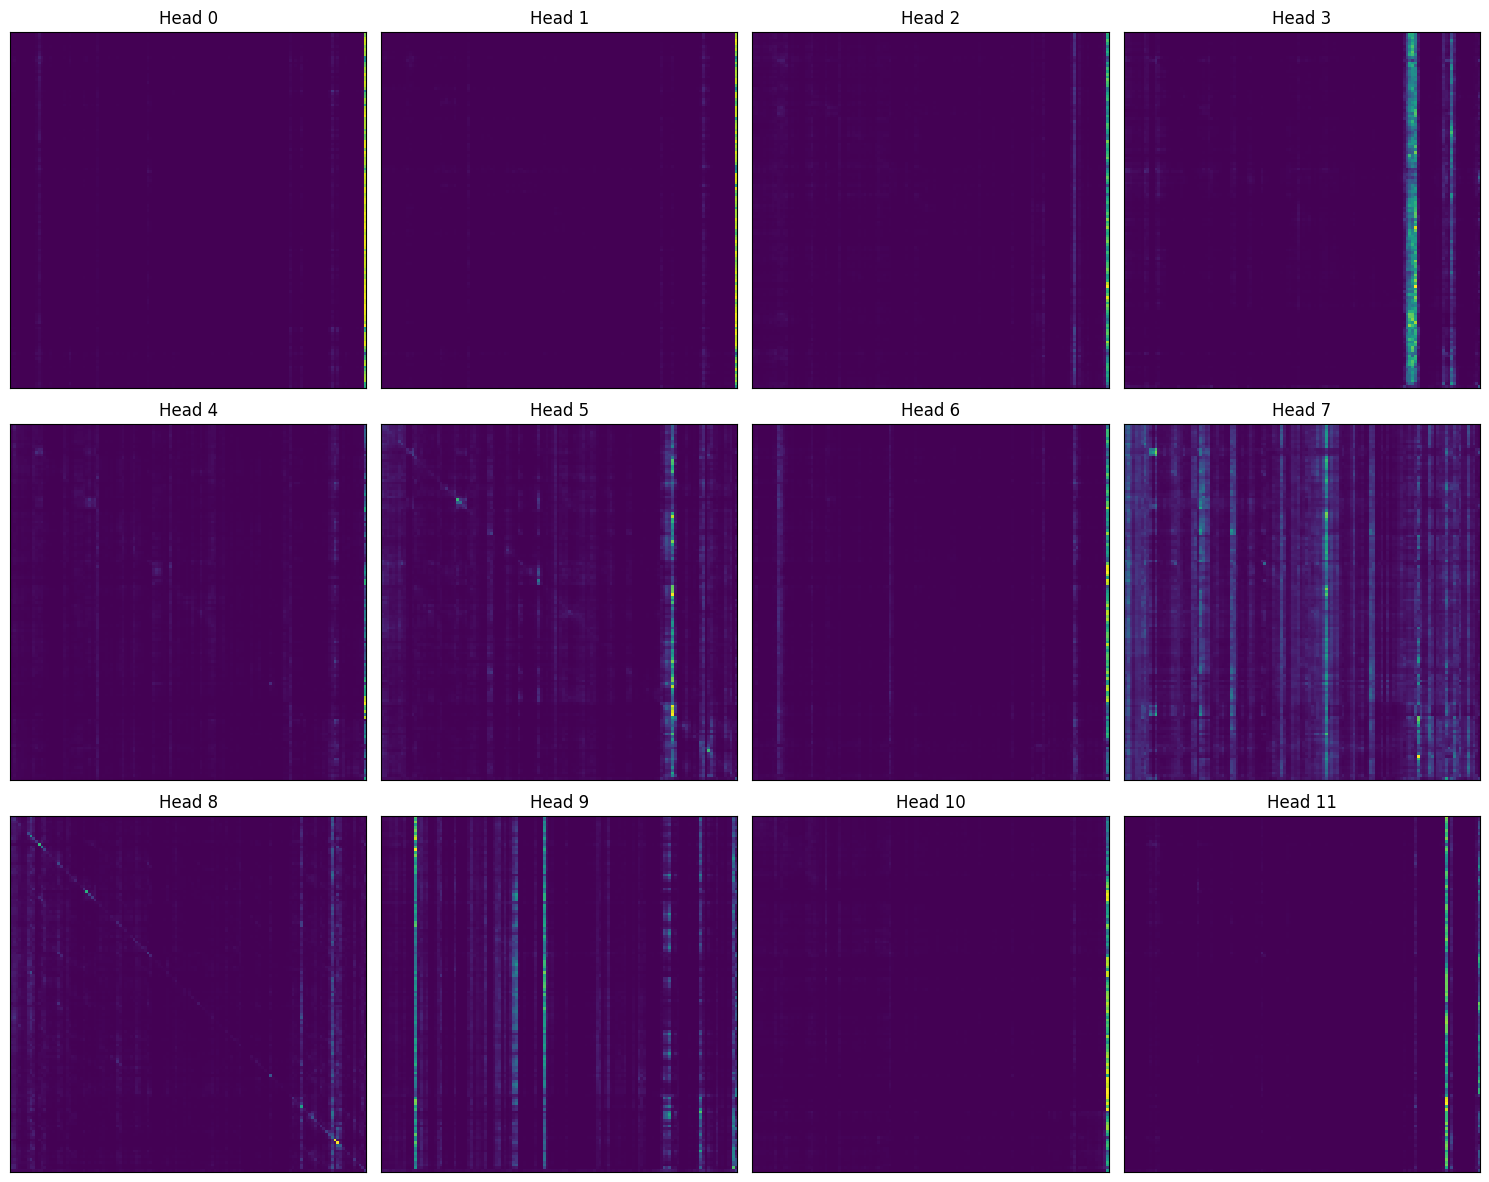


Label name: toxic_correct
Index:      103
True combo: (1, 0, 0, 0, 0, 0)
Pred combo: (1, 0, 0, 0, 0, 0)
TEXT: stop the mad gorilla deleter! gorilla scolded me about inserting whisperback on any talk page but my own. i don ' t give a flying rhymes with muck! pages deleted 1770 pages restored 64 pages protected 93 gorilla scolded me about inserting whisperback on any talk page but my own. i don ' t take orders from you, gorilla. this is my last communique with you female napoleon! what a wikinazi! pages unprotected 10 protections modified 31 users blocked 562 users reblocked 46 users unblocked 22 user rights modified 16 that felt gooood! go


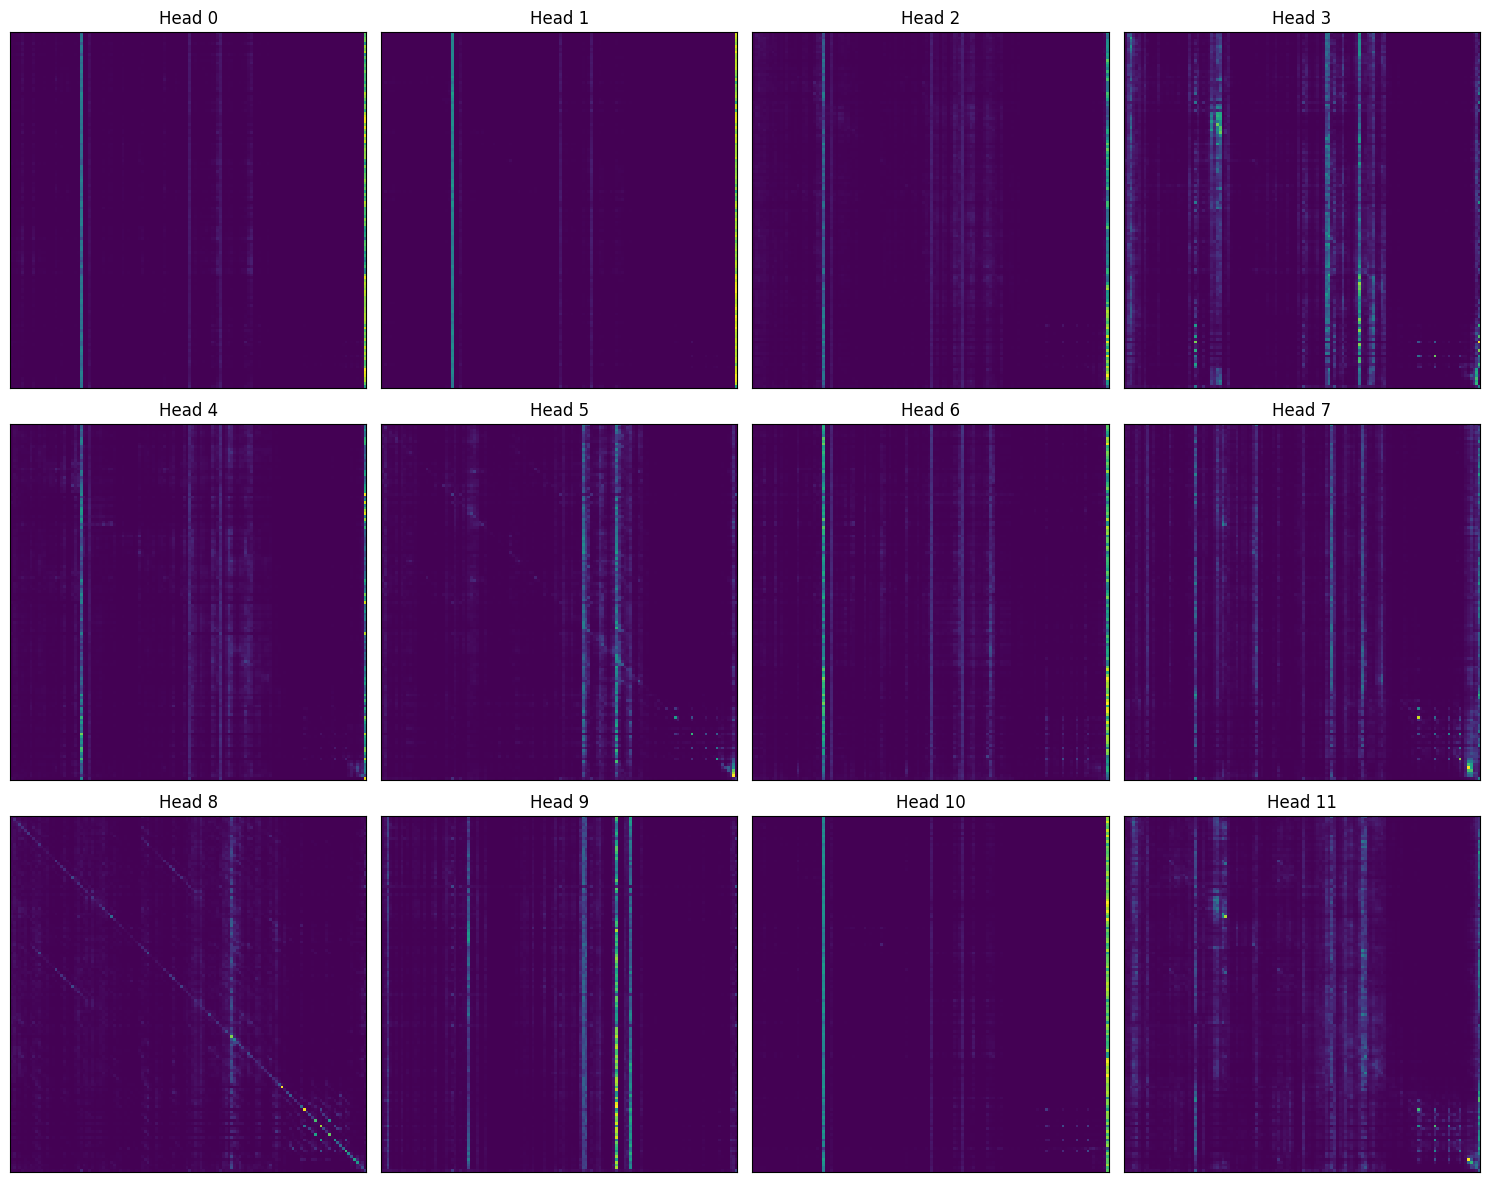


Label name: toxic_wrong
Index:      14
True combo: (1, 0, 0, 0, 0, 0)
Pred combo: (0, 0, 0, 0, 0, 0)
TEXT: stay out of it it ' s none of your business


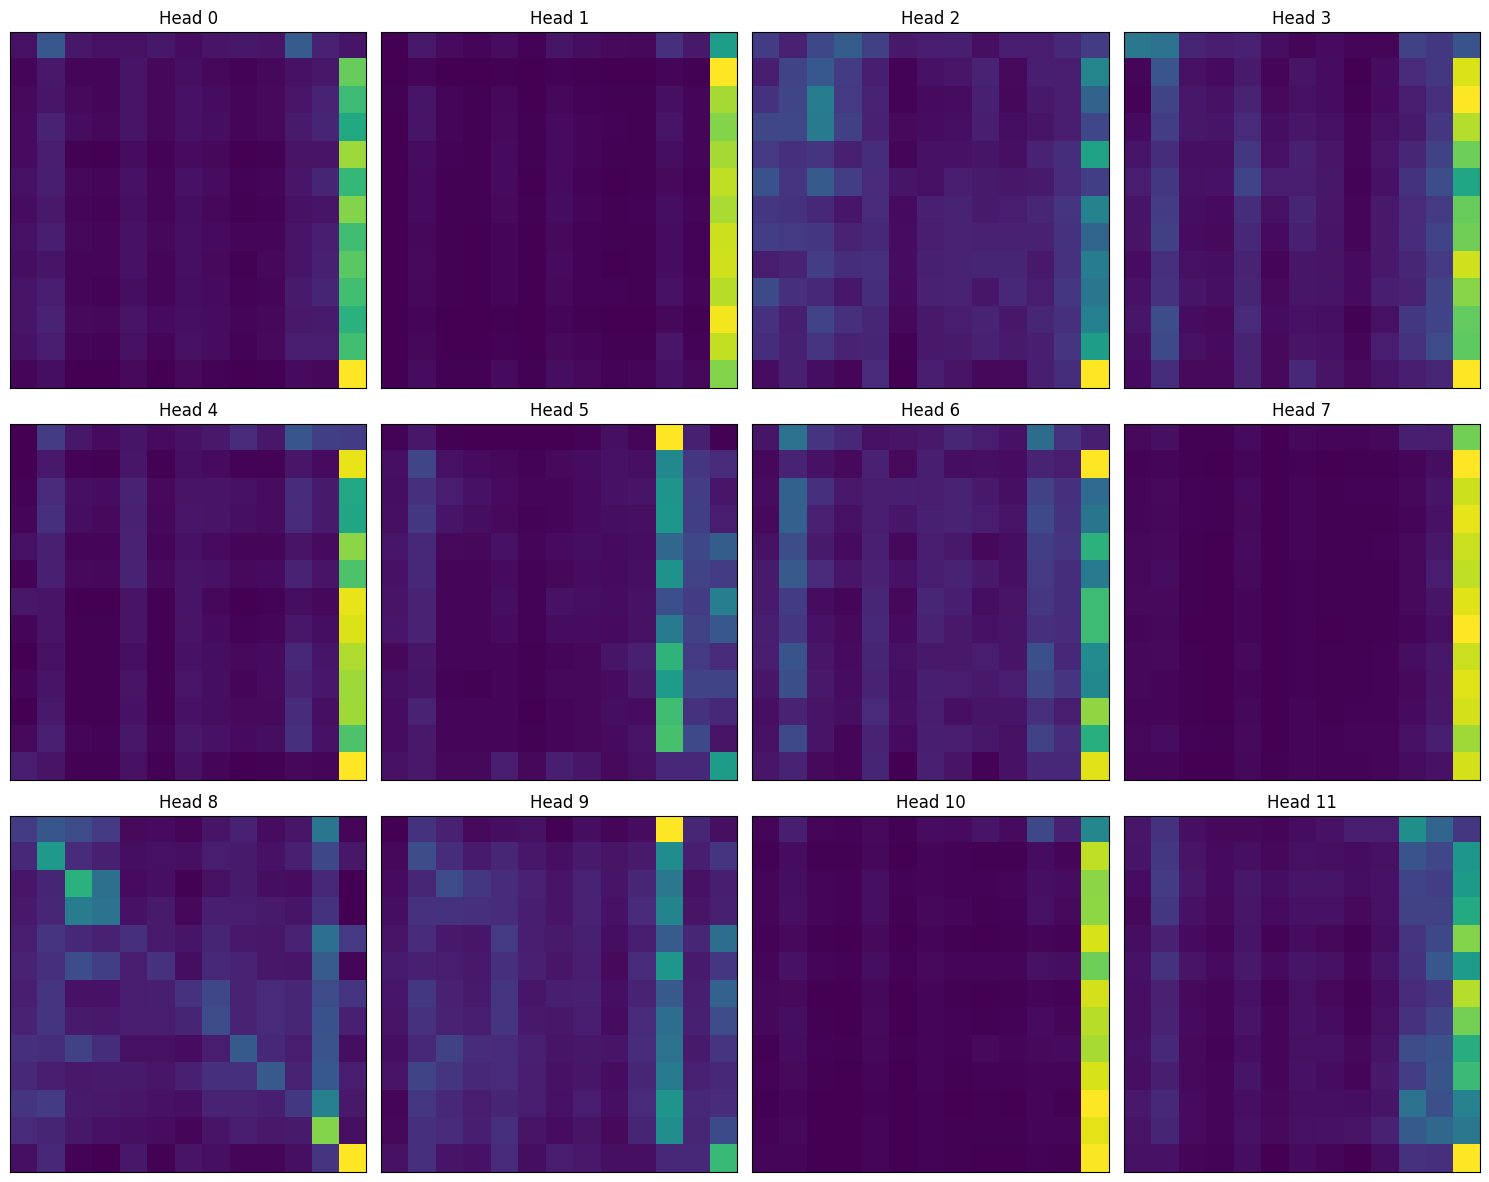


Label name: toxic_identity_correct
Index:      865
True combo: (1, 0, 0, 0, 0, 1)
Pred combo: (1, 0, 0, 0, 0, 1)
TEXT: i ' m just trying to stop those arab - hating jews. drive them into the sea!


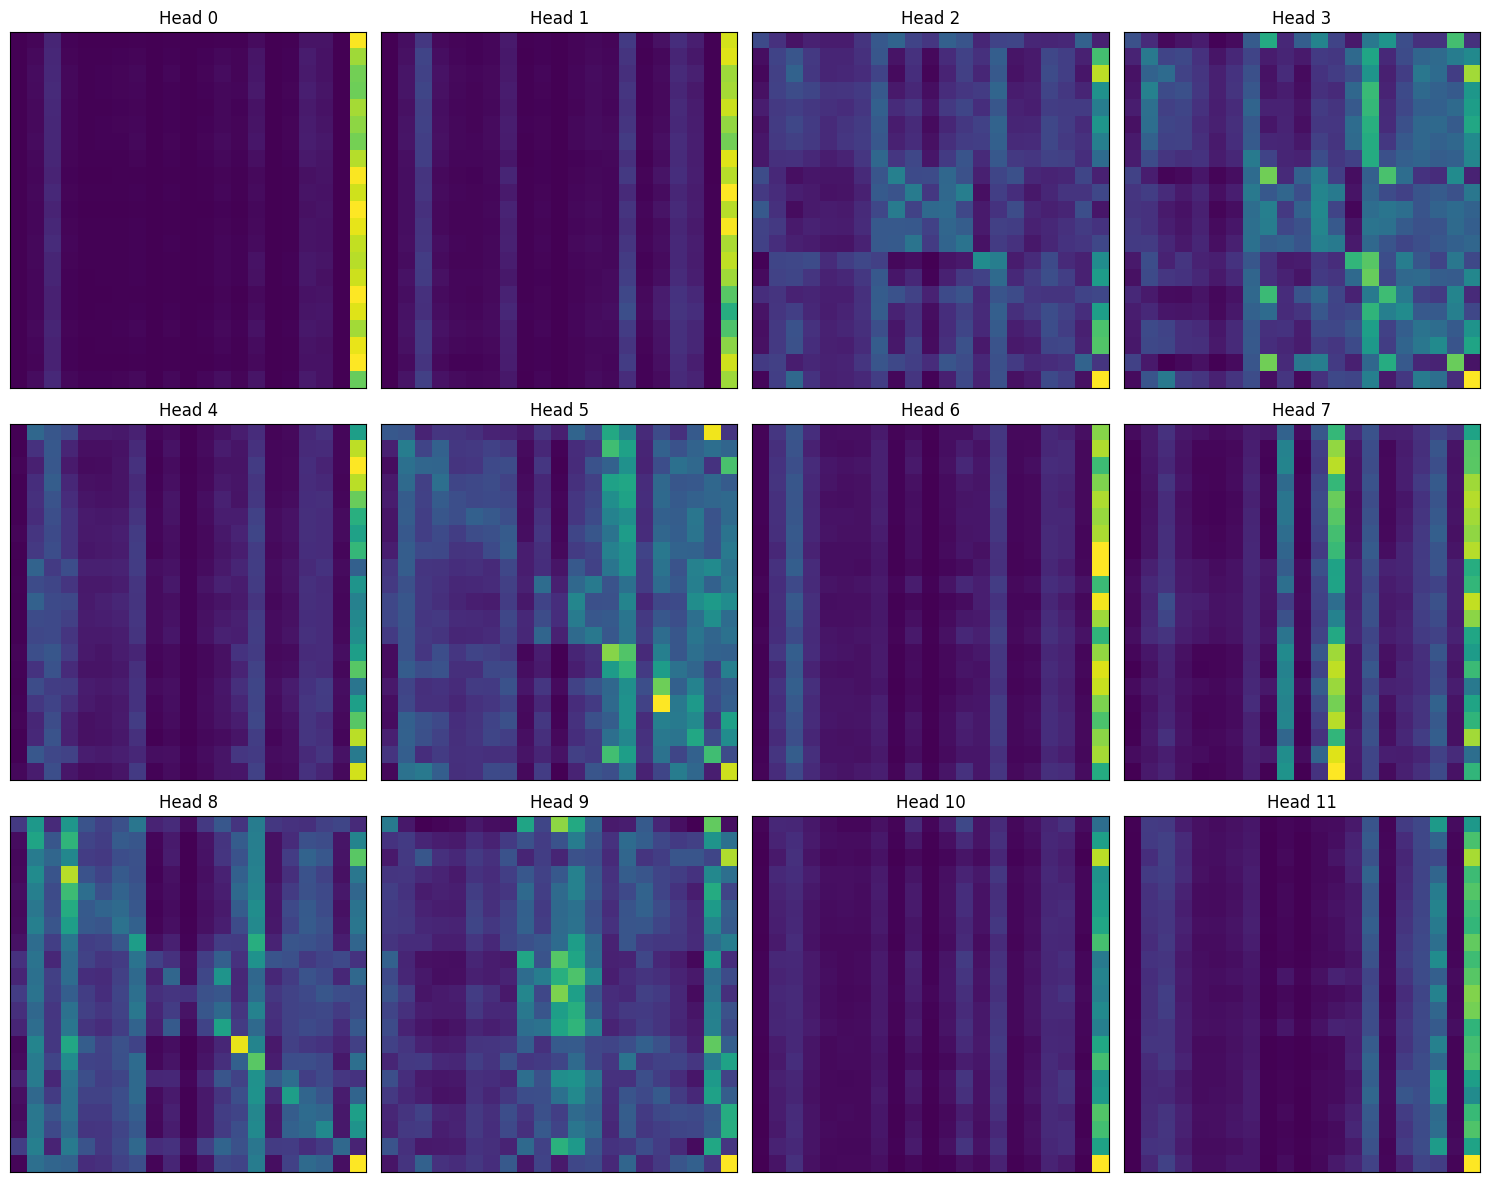


Label name: threat_correct
Index:      949
True combo: (1, 0, 0, 1, 0, 0)
Pred combo: (1, 0, 0, 1, 0, 0)
TEXT: loganberry i will kill u first


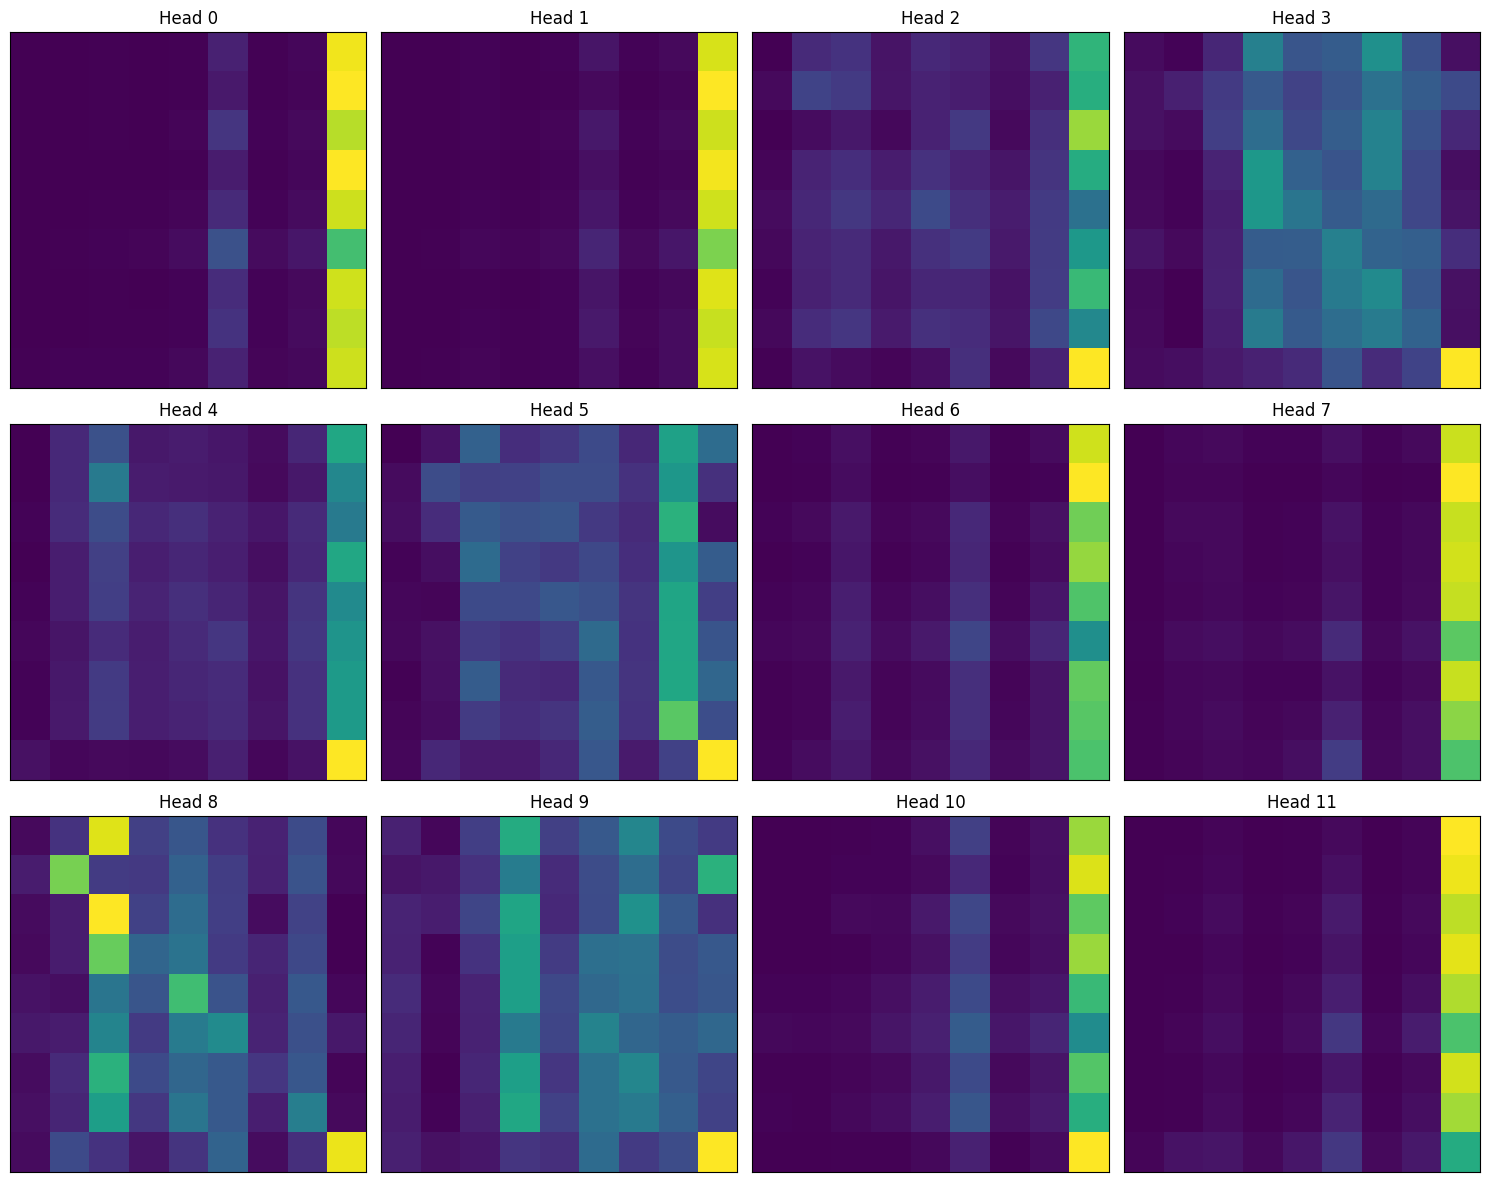


Label name: multi_correct
Index:      424
True combo: (1, 0, 1, 0, 1, 1)
Pred combo: (1, 0, 1, 0, 1, 1)
TEXT: message go fuck loy wong, you dirty, old, white, asian basher. also, i am 767 - 249er 122. 106. 59. 22


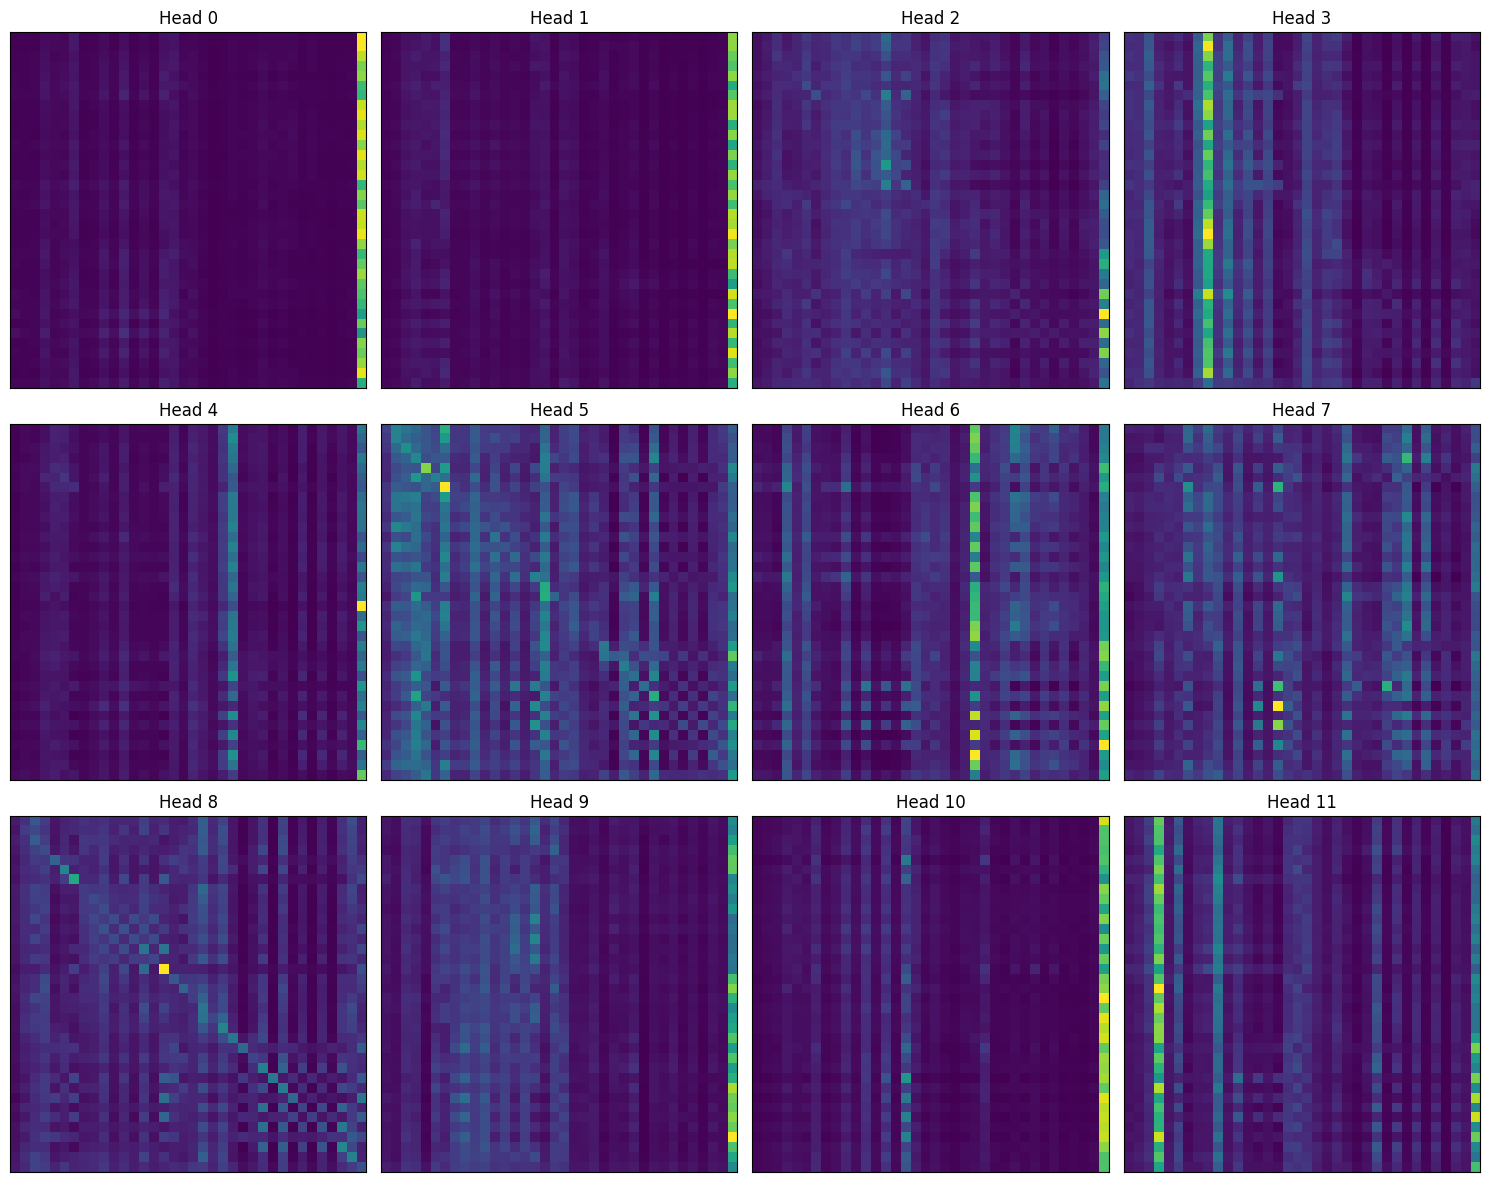


Label name: max_toxic_wrong
Index:      469
True combo: (1, 1, 1, 1, 1, 1)
Pred combo: (1, 1, 1, 1, 1, 0)
TEXT: anyone who supports this is fucking sick. men and underaged fucking kids?????????????????????????????? what in the fuck you all should be shot and killed you bunch of fucking faggot pedophiles die die die die di edie die die die die die die die die di edie die die die die die die die die di edie die die die die die die die die di edie die die die die die die die die di edie die die die die die die die die di


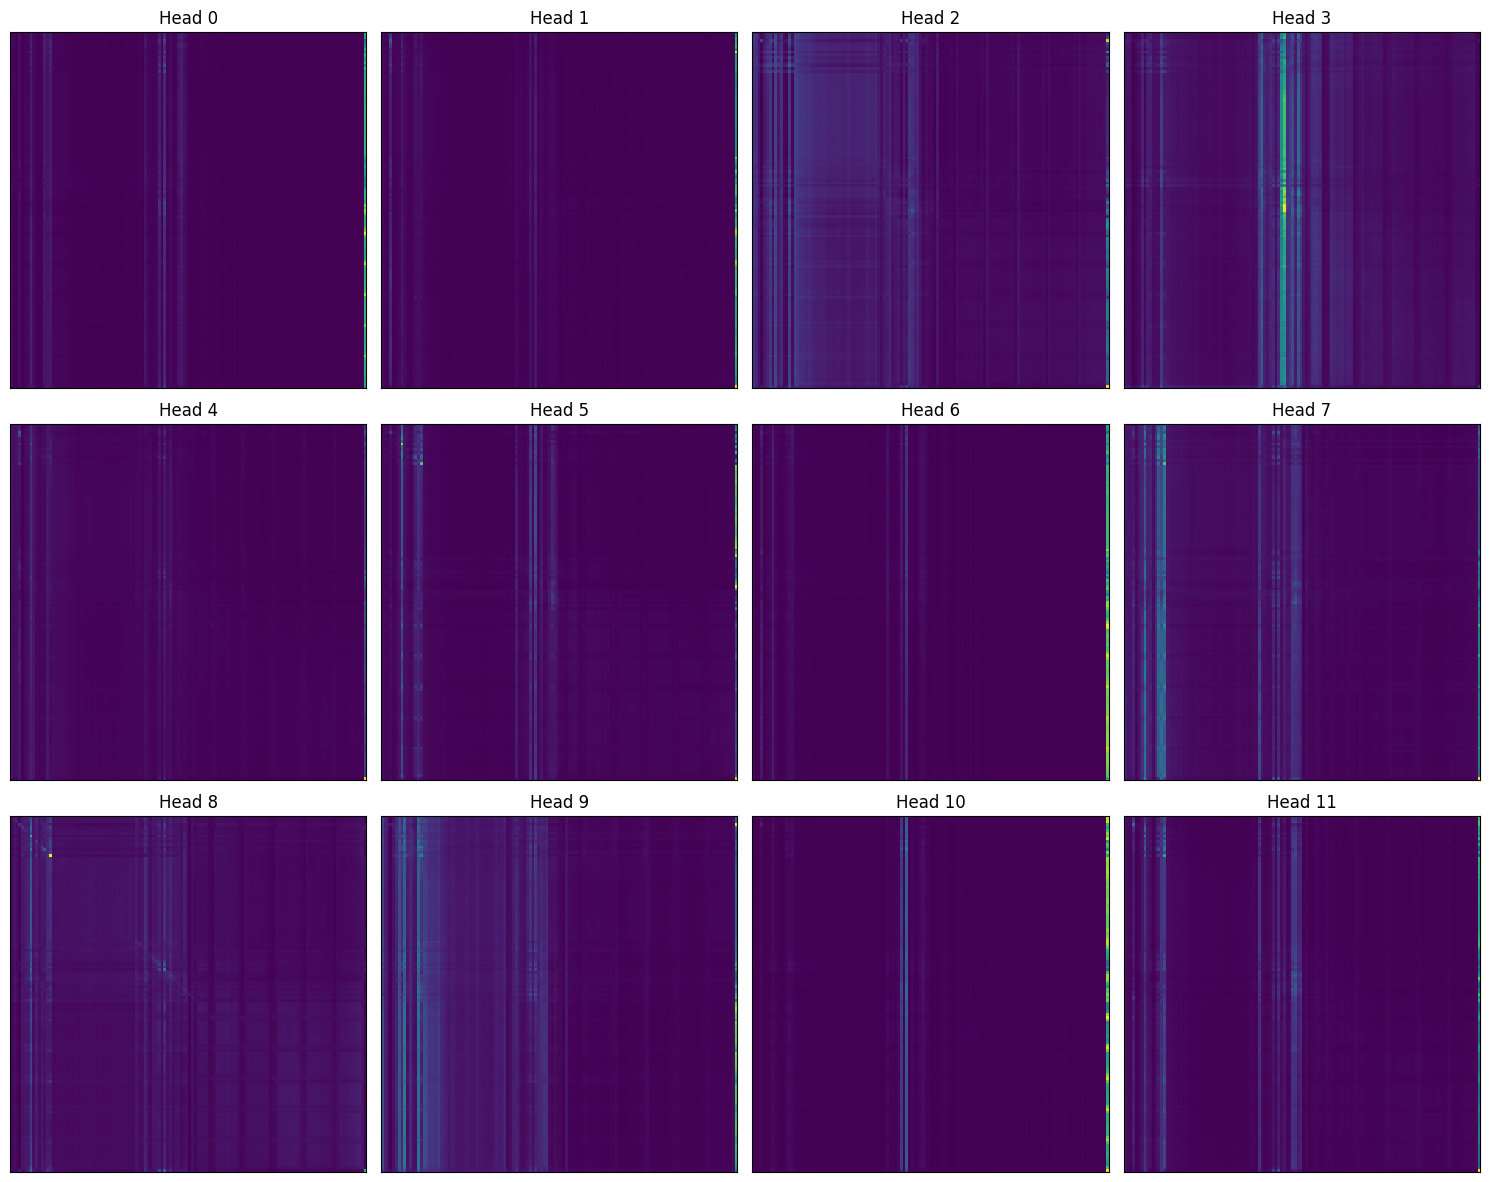

In [68]:
LAYER = 5  # 0 to 5 heads

for ex in examples:
    print("\n====================================")
    print(f"Label name: {ex['label']}")
    print(f"Index:      {ex['index']}")
    print(f"True combo: {ex['true_combo']}")
    print(f"Pred combo: {ex['pred_combo']}")
    print("TEXT:", ex['text'])

    tokens, attentions = get_attention(ex["text"])
    attention_matrix = attentions[LAYER][0]  # (num_heads, seq_len, seq_len)

    plot_all_heads(tokens, attention_matrix, ex['label'], LAYER)

The visualization of attention across a model's heads and layers reveals distinct structural patterns.

Lower layers typically focus attention in a very strong, diagonal manner, suggesting a high emphasis on local context.

Higher layers, show more diffuse interactions, indicating that attention is spread across a wider range of tokens for contextual understanding.

In [50]:
def top_k_attended_tokens(tokens, attention_matrix, k=5):
    """
    Given a single attention head matrix (seq_len x seq_len),
    returns the k tokens with the highest total incoming attention.
    """
    attn = attention_matrix.cpu().numpy()

    # Sum attention each token receives across all queries
    incoming_attention = attn.sum(axis=0)

    # Top-k indices
    top_idx = np.argsort(incoming_attention)[-k:][::-1]

    return [(tokens[i], float(incoming_attention[i])) for i in top_idx]


In [58]:
print("CLASS NAMES:", id2label)
for combo, data in combos.items():
    print(combo)
    for ex, ex_text in data.items():
        if ex_text is not None:
            print(ex)
            tokens, attentions = get_attention(ex_text['text'])
            head_matrix = attentions[0][0][0]  # layer 0, batch 0, head 0

            top_tokens = top_k_attended_tokens(tokens, head_matrix, k=10)
            print(top_tokens)
    print("\n")


CLASS NAMES: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(0, 0, 0, 0, 0, 0)
correct
[('##bury', 2.6391263008117676), ('##yan', 2.463233470916748), ('##ologist', 2.376765251159668), ('[CLS]', 2.354219436645508), ('commence', 2.2977375984191895), ('##nsor', 2.2686219215393066), ('censorship', 2.0848135948181152), ('intelligent', 2.0445258617401123), ('censorship', 2.042940616607666), ('trying', 1.914284586906433)]
wrong
[('matthew', 3.774113178253174), ('poison', 3.682255983352661), ('matthew', 3.5450549125671387), ('deadly', 3.1414785385131836), ('evil', 2.891789674758911), ('bless', 2.861992835998535), ('condemned', 2.548311948776245), ('[CLS]', 2.477180242538452), ('idle', 2.415512800216675), ('tame', 2.405578374862671)]


(1, 1, 1, 0, 1, 0)
correct
[('[CLS]', 1.4914641380310059), ('fuck', 1.443400502204895), ('[SEP]', 1.3890256881713867), ('##ker', 0.7333694100379944), ('wan', 0.5806965231895447), ('you', 0.3620435893535614)]
wrong
[('[CLS]', 2.025441646

The analysis of top-attended tokens across model layers reveals several consistent patterns, particularly in relation to the ground-truth labels.

Neutral Examples
- In a correctly classified neutral example (e.g., combo 0,0,0,0,0,0), the model primarily attends to structural tokens like [CLS] and different words such as “##bury” or “##nsor.” This is logical, as the text is long and lacks overt toxicity, meaning no single semantic token strongly stands out.
- However, in a misclassified neutral case, attention abruptly shifts to emotionally loaded words, including “matthew,” “poison,” “deadly,” “evil,” and “condemned.” These tokens appear to drive the model’s incorrect prediction of toxicity, despite the comment’s true neutral status.
 
Toxic and Obscene Examples
For examples containing toxic or obscene content, the attention patterns align much more closely with the offensive vocabulary:
- In a correct prediction (e.g., combo (1,1,1,0,1,0)), the most attended tokens are explicit, such as “fuck,” “##ker,” and “wan.”
- In the corresponding wrong prediction, the model still focuses heavily on explicit words like “fuck,” “hell,” and “burn,” which explains the tendency to over-predict certain additional toxic labels.

Identity Hate and Threat Examples
Similar behaviors are observed in other categories:
- Identity Hate (idx 865): “jews,” “arab,” “hating,” and “drive” - all relevant to the ground-truth labels. “bitter,” “destroyed,” “holder,” and “missiles” - unrelated words are prioritized. Attention on irrelevant words fits with the failure to detect identity-hate.
- Threat (idx 949): “kill,” “logan,” and “first” - clearly related to the threat label. “whoever,” “death,” and “##fide” - more ambiguous words are prioritized. Ambiguity in attended words likely explains why the threat label was missed.

Extremely Toxic Cases
For the most severe combinations (e.g., (1,1,1,1,1,0) and (1,1,1,1,1,1)), attention is almost entirely dominated by strong swear words like “fuck,” “fucking,” “bitch,” “##phile,” and “die.” This confirms the observation that these examples are generally easier for the model, as the toxic content is obvious. Even when occasional mistakes occur, the top-attended words still clearly indicate the basis for the model's tendency toward a heavily toxic classification.

Overall, attention patterns largely make sense concerning which words the model consider important, especially when offensive keywords are present. However, the analysis of incorrect predictions consistently demonstrates that the model often attends to emotionally strong but contextually unrelated words, which explains both false positives and false negatives.

## Saliency Maps

In [81]:
error_analysis = {label: {"correct": None, "wrong": None} for label in id2label}

for combo, data in combos.items():
    true = combo
    corr = data.get("correct")
    wrong = data.get("wrong")

    # Check correct example
    if corr:
        pred = corr["combo_pred"]
        for i, label_name in enumerate(id2label):
            if true[i] == 1 and pred[i] == 1:
                if error_analysis[label_name]["correct"] is None:
                    error_analysis[label_name]["correct"] = corr

    # Check wrong example
    if wrong:
        pred = wrong["combo_pred"]
        for i, label_name in enumerate(id2label):
            # CASE 1: false negative -> should be 1 but model puts 0
            if true[i] == 1 and pred[i] == 0:
                if error_analysis[label_name]["wrong"] is None:
                    error_analysis[label_name]["wrong"] = wrong

            # CASE 2: false positive -> true = 0 but model puts 1
            if true[i] == 0 and pred[i] == 1:
                if error_analysis[label_name]["wrong"] is None:
                    error_analysis[label_name]["wrong"] = wrong

error_analysis


{'toxic': {'correct': {'index': 4,
   'text': 'fuck you wanker',
   'combo_true': (1, 1, 1, 0, 1, 0),
   'combo_pred': (1, 1, 1, 0, 1, 0)},
  'wrong': {'index': 43,
   'text': '" your mouth is your worst enemy guy matthew 7 : 12 " " therefore whatever you want men to do to you, do also to them, for this is the law and the prophets " " matthew 12 : 36 - 37 " " but i say to you that for every idle word men may speak, they will give account of it in the day of judgement " " " " for your words you will be justified and your words you will be condemned " " james 3 : 8 but no man cam tame the tongue, it is an unruly evil, full of deadly poison. james 3 : 9 with it we bless our',
   'combo_true': (0, 0, 0, 0, 0, 0),
   'combo_pred': (1, 0, 0, 0, 0, 0)}},
 'severe_toxic': {'correct': {'index': 4,
   'text': 'fuck you wanker',
   'combo_true': (1, 1, 1, 0, 1, 0),
   'combo_pred': (1, 1, 1, 0, 1, 0)},
  'wrong': {'index': 110,
   'text': 'you are a douche bag die and burn in hell',
   'combo_tru

In [86]:
def compute_saliency_for_label(text, model, tokenizer, label_idx):
    """
    Computes gradient-based saliency map for a specific class index in a multilabel classifier.
    Uses gradients wrt input embeddings (correct way).
    """

    # Tokenize
    encoded = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding=True
    ).to(model.device)

    input_ids = encoded["input_ids"]
    attention_mask = encoded["attention_mask"]

    # Get embeddings and enable gradient
    embeddings = model.get_input_embeddings()(input_ids)
    embeddings.retain_grad()
    embeddings.requires_grad_(True)

    # Forward pass using inputs_embeds instead of input_ids
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    logits = outputs.logits.squeeze(0)

    # Select the target class
    target_logit = logits[label_idx]

    # Backward
    model.zero_grad()
    target_logit.backward()

    # Gradient wrt embeddings
    grads = embeddings.grad[0]          # shape: (seq_len, hidden_dim)
    emb = embeddings[0]

    # Saliency = sum(|grad * emb|) over embedding dimensions
    saliency = (grads * emb).abs().sum(dim=-1).detach().cpu().numpy()

    # Convert tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    return tokens, saliency


In [96]:
def plot_saliency(tokens, saliency, label, corr, title="Saliency"):
    plt.figure(figsize=(18,2))
    plt.bar(range(len(tokens)), saliency)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"saliency_maps/{label}_{corr}")
    plt.show()

In [91]:
id2label

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

We are going to look at gradient-based saliency maps to figure out why the model gets toxicity labels right or wrong. For every single label, we compare a correct example with an incorrect one, measuring exactly which tokens the model is paying attention to for that specific label’s score. This comparison lets us quickly spot if the model is ignoring the crucial toxic words, focusing on random irrelevant words, or getting confused between similar labels. It’s a concrete way to understand the model's errors for each type of toxicity instead of just guessing.

### LABEL: TOXIC

✔ CORRECT prediction
Index: 4
True: (1, 1, 1, 0, 1, 0)
Pred: (1, 1, 1, 0, 1, 0)
TEXT: fuck you wanker


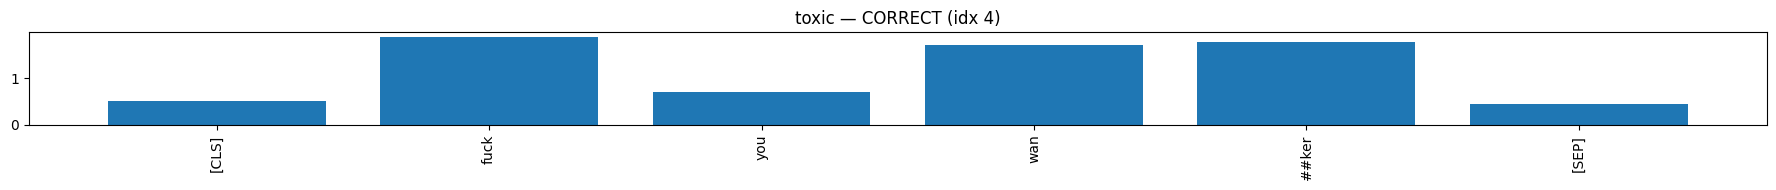


✘ WRONG prediction
Index: 43
True: (0, 0, 0, 0, 0, 0)
Pred: (1, 0, 0, 0, 0, 0)
TEXT: " your mouth is your worst enemy guy matthew 7 : 12 " " therefore whatever you want men to do to you, do also to them, for this is the law and the prophets " " matthew 12 : 36 - 37 " " but i say to you that for every idle word men may speak, they will give account of it in the day of judgement " " " " for your words you will be justified and your words you will be condemned " " james 3 : 8 but no man cam tame the tongue, it is an unruly evil, full of deadly poison. james 3 : 9 with it we bless our


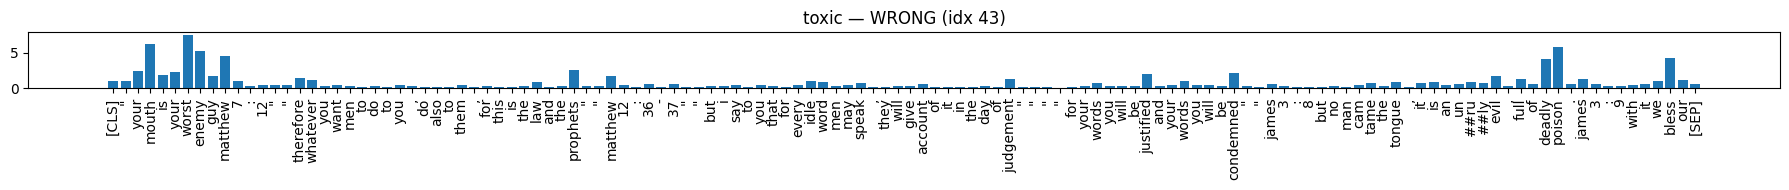

### LABEL: SEVERE_TOXIC

✔ CORRECT prediction
Index: 4
True: (1, 1, 1, 0, 1, 0)
Pred: (1, 1, 1, 0, 1, 0)
TEXT: fuck you wanker


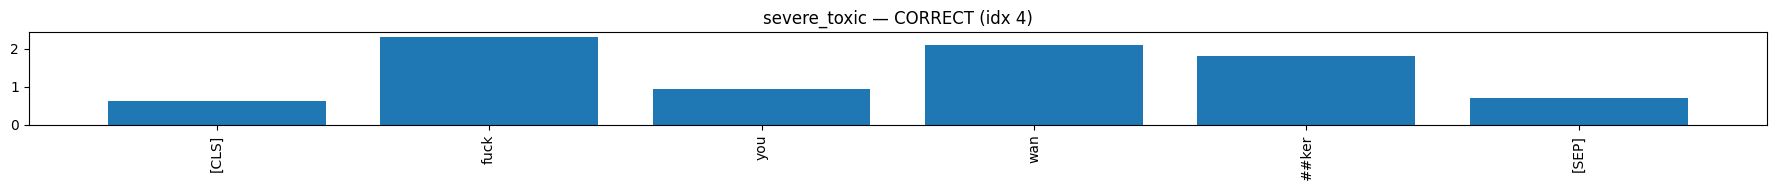


✘ WRONG prediction
Index: 110
True: (1, 1, 1, 0, 1, 0)
Pred: (1, 0, 1, 1, 1, 0)
TEXT: you are a douche bag die and burn in hell


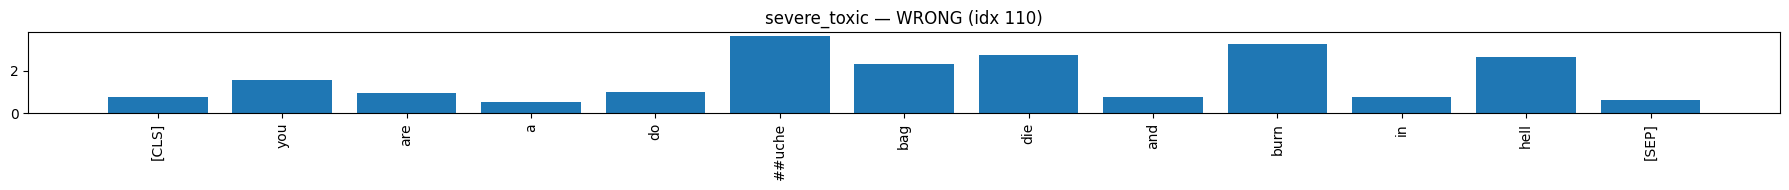

### LABEL: OBSCENE

✔ CORRECT prediction
Index: 4
True: (1, 1, 1, 0, 1, 0)
Pred: (1, 1, 1, 0, 1, 0)
TEXT: fuck you wanker


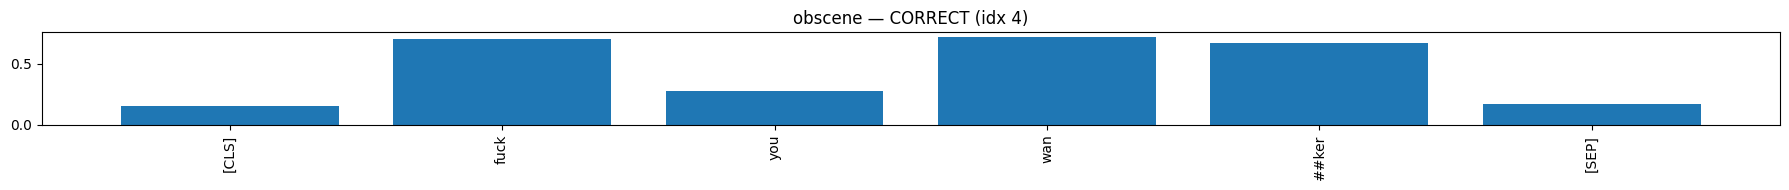


✘ WRONG prediction
Index: 566
True: (1, 0, 1, 1, 1, 0)
Pred: (1, 0, 0, 0, 0, 0)
TEXT: unban this ip address or a new online encyclopedia will be formed that will kick wikipedia ' s ass. you have been warned teeeccccctooooniiiiiiiicccccc shhhhhiiiiiiiifffffffftttttttt


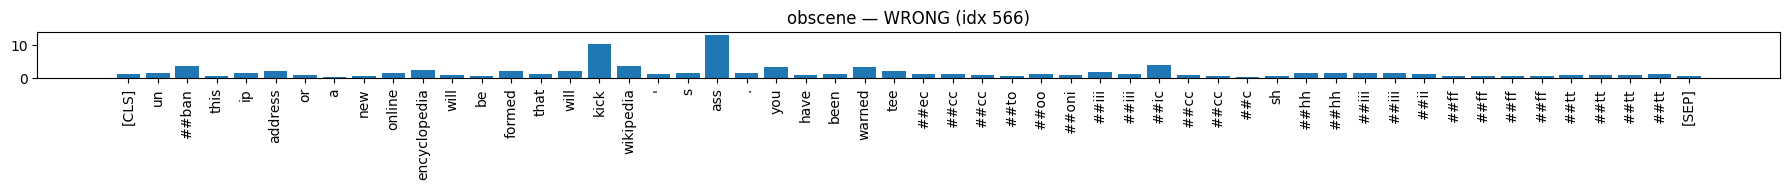

### LABEL: THREAT

✔ CORRECT prediction
Index: 6492
True: (1, 0, 1, 1, 1, 0)
Pred: (1, 0, 1, 1, 1, 0)
TEXT: yo, as * hole im gonna kill you and steal ur huge monitor!


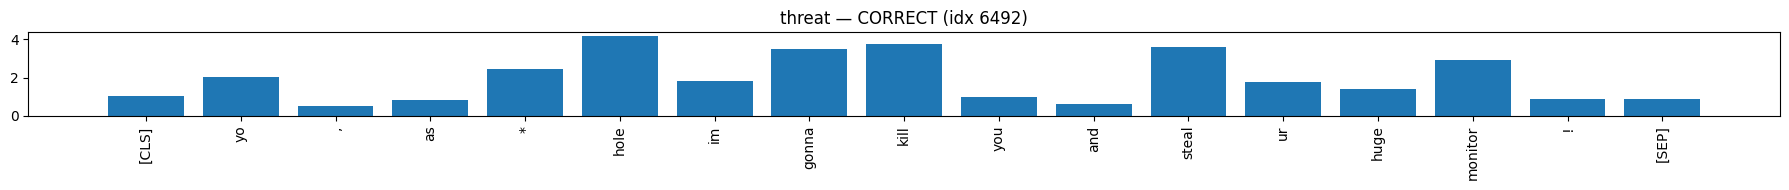


✘ WRONG prediction
Index: 110
True: (1, 1, 1, 0, 1, 0)
Pred: (1, 0, 1, 1, 1, 0)
TEXT: you are a douche bag die and burn in hell


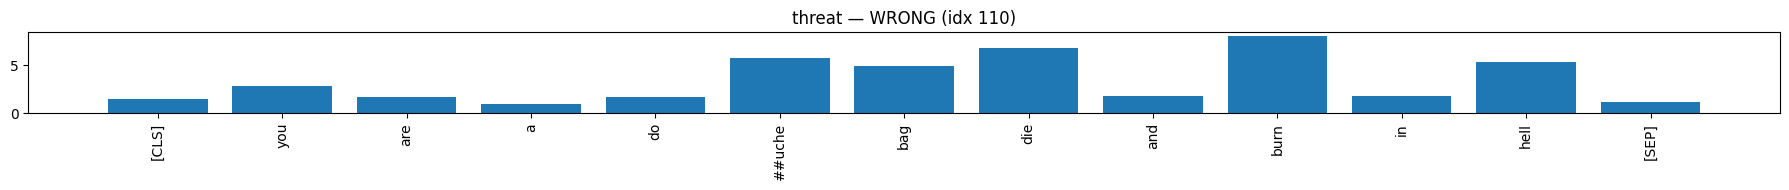

### LABEL: INSULT

✔ CORRECT prediction
Index: 4
True: (1, 1, 1, 0, 1, 0)
Pred: (1, 1, 1, 0, 1, 0)
TEXT: fuck you wanker


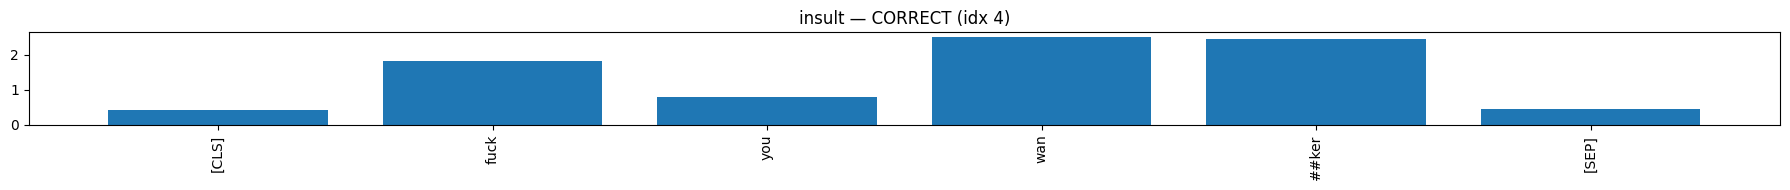


✘ WRONG prediction
Index: 265
True: (1, 0, 0, 0, 1, 0)
Pred: (1, 0, 0, 0, 0, 0)
TEXT: i think he ' s a prick.


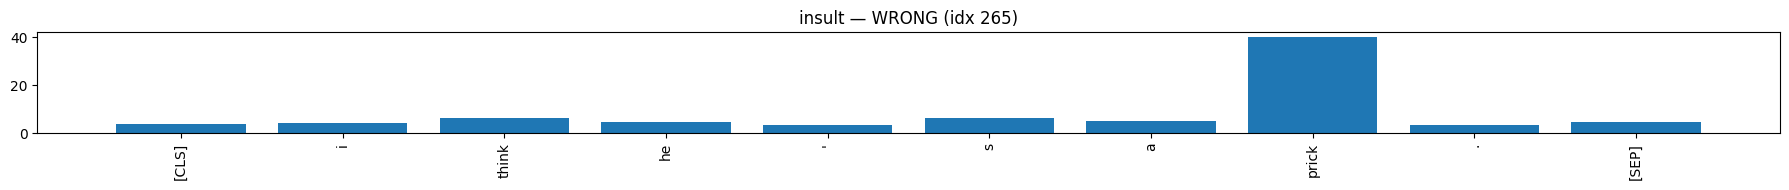

### LABEL: IDENTITY_HATE

✔ CORRECT prediction
Index: 1678
True: (1, 1, 1, 0, 1, 1)
Pred: (1, 1, 1, 0, 1, 1)
TEXT: suck my dick irish guy you faggot


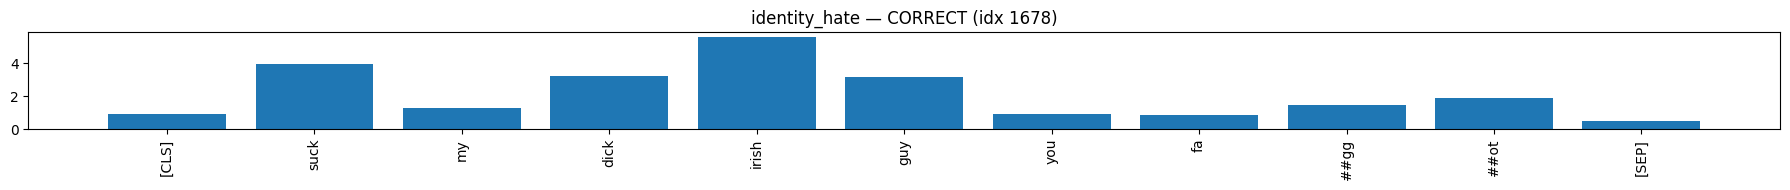


✘ WRONG prediction
Index: 286
True: (1, 0, 0, 0, 0, 1)
Pred: (1, 0, 0, 0, 0, 0)
TEXT: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ yes yes yes, 094 conducted patrol in 2014 without missiles. the chinese are so stupid that they can not even make a missile work. go ahead usa start a nuclear war now with china. you most hated and bitter enemy. they utterly destroyed your economy and is your biggest debt holder. go ahead usa nuke


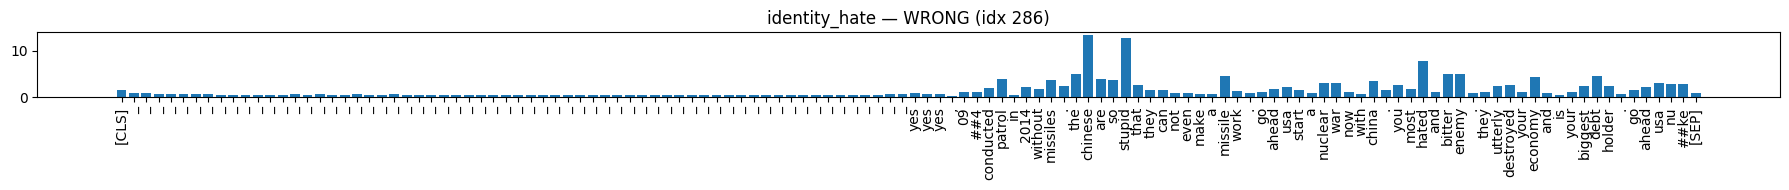

In [99]:
for label in id2label:
    print("="*100)
    print(f"### LABEL: {label.upper()}")

    pair = error_analysis[label]
    corr = pair["correct"]
    wrong = pair["wrong"]

    if corr is None or wrong is None:
        print(f"Skipping {label}: missing correct or wrong example.")
        continue

    label_idx = id2label.index(label)  # ← este es el label que vamos a explicar

    # ------------------------------------------------------------------
    # CORRECT EXAMPLE
    # ------------------------------------------------------------------
    print("\n✔ CORRECT prediction")
    print("Index:", corr["index"])
    print("True:", corr["combo_true"])
    print("Pred:", corr["combo_pred"])
    print("TEXT:", corr["text"])

    tokens, sal = compute_saliency_for_label(
        corr["text"], model, tokenizer, label_idx
    )

    plot_saliency(tokens, sal, label, "correct", title=f"{label} — CORRECT (idx {corr['index']})")

    # ------------------------------------------------------------------
    # WRONG EXAMPLE
    # ------------------------------------------------------------------
    print("\n✘ WRONG prediction")
    print("Index:", wrong["index"])
    print("True:", wrong["combo_true"])
    print("Pred:", wrong["combo_pred"])
    print("TEXT:", wrong["text"])

    tokens, sal = compute_saliency_for_label(
        wrong["text"], model, tokenizer, label_idx
    )

    plot_saliency(tokens, sal, label, "incorrect", title=f"{label} — WRONG (idx {wrong['index']})")


## LIME for NLP

## SHAP